In [1]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch

In [2]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [3]:
A = 1.2
b = -0.3
sigma = 0.2
N = 100

In [4]:
np.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [5]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()

In [6]:
y = A*X + b + e

In [7]:
y.detach()
y = y.float()

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [9]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [10]:
def log_q_pdf(w, theta):
    (mu_A, mu_b, rho_A, rho_b) = theta 
    
    sigma_A = rho_to_sigma(rho_A)
    qA = torch.distributions.normal.Normal(mu_A, sigma_A)
    
    sigma_b = rho_to_sigma(rho_b)
    qb = torch.distributions.normal.Normal(mu_b, sigma_b)
    
    lp = qA.log_prob(w[0]) + qb.log_prob(w[1])
    return lp

In [11]:
def log_p_pdf(w):
    prior_mu_A = torch.tensor(0.0) 
    prior_sigma_A = torch.tensor(1.0)
    pA = torch.distributions.normal.Normal(prior_mu_A, prior_sigma_A)
    
    prior_mu_b = torch.tensor(0.0) 
    prior_sigma_b = torch.tensor(1.0)
    pb = torch.distributions.normal.Normal(prior_mu_b, prior_sigma_b)
    
    lp = pA.log_prob(w[0]) + pb.log_prob(w[1])
    return lp

In [12]:
def likelihood(y,X,w):
    A = w[0]
    b = w[1]
    
    y_pred = A*X + b
    lp = torch.distributions.normal.Normal(y_pred, 0.2).log_prob(y).sum()
    return lp

In [13]:
def f(w, theta):
    v = log_q_pdf(w, theta) - log_p_pdf(w) - likelihood(y,X,w)
    return v

In [36]:
mu_A = torch.tensor(0.0)
sigma_A = torch.tensor(0.1)
rho_A = sigma_to_rho(sigma_A)
mu_b = torch.tensor(0.0)
sigma_b = torch.tensor(0.1)
rho_b = sigma_to_rho(sigma_b)

theta = torch.tensor([mu_A, mu_b, rho_A, rho_b], requires_grad=True)

In [37]:
alpha = torch.tensor(10e-5)

In [38]:
for i in range(0,10000):
    lst_grad_mu = []
    lst_grad_rho = []
    lst_v = []
    for j in range(0,20):
        epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

        with torch.no_grad():
            w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
        w.requires_grad = True

        v = f(w, theta)   
        v.backward()
        lst_v.append(v.data)
        v = torch.tensor([])

        with torch.no_grad():
            grad_mu = w.grad + theta.grad[0:2]
            grad_rho = w.grad*epsilon/(1 + torch.exp(-theta[2:4])) + -theta.grad[2:4]


        lst_grad_mu.append(grad_mu)
        lst_grad_rho.append(grad_rho)

        theta.grad.zero_()
        w.grad.zero_()
        v.detach()
    grad_mu = torch.stack(lst_grad_mu).mean(dim=0)
    grad_rho = torch.stack(lst_grad_rho).mean(dim=0)
    
    print(torch.stack(lst_v).mean())
    #print(grad_mu)
    #print(grad_rho)
        
    with torch.no_grad():
        theta[0:2] -= alpha*grad_mu
        theta[2:4] -= alpha*grad_rho
    
    print(theta)



tensor(263.5126)
tensor([ 0.0619,  0.0793, -2.2516, -2.2552], requires_grad=True)
tensor(187.0654)
tensor([ 0.1104,  0.1321, -2.2522, -2.2579], requires_grad=True)
tensor(133.7341)
tensor([ 0.1440,  0.1560, -2.2528, -2.2598], requires_grad=True)
tensor(131.6735)
tensor([ 0.1806,  0.1870, -2.2542, -2.2621], requires_grad=True)
tensor(100.2494)
tensor([ 0.2026,  0.1898, -2.2546, -2.2636], requires_grad=True)
tensor(106.3557)
tensor([ 0.2279,  0.1991, -2.2560, -2.2656], requires_grad=True)
tensor(95.0415)
tensor([ 0.2456,  0.1939, -2.2566, -2.2674], requires_grad=True)
tensor(99.3392)
tensor([ 0.2668,  0.1953, -2.2580, -2.2693], requires_grad=True)
tensor(84.3474)
tensor([ 0.2862,  0.1950, -2.2588, -2.2703], requires_grad=True)
tensor(78.9031)
tensor([ 0.3057,  0.1969, -2.2594, -2.2717], requires_grad=True)
tensor(81.7566)
tensor([ 0.3201,  0.1890, -2.2603, -2.2737], requires_grad=True)
tensor(78.9737)
tensor([ 0.3378,  0.1878, -2.2613, -2.2754], requires_grad=True)
tensor(72.4975)
tensor

tensor([ 1.0088, -0.1640, -2.3210, -2.4526], requires_grad=True)
tensor(2.3726)
tensor([ 1.0104, -0.1679, -2.3218, -2.4543], requires_grad=True)
tensor(-4.3443)
tensor([ 1.0103, -0.1739, -2.3223, -2.4552], requires_grad=True)
tensor(-2.4703)
tensor([ 1.0151, -0.1720, -2.3223, -2.4567], requires_grad=True)
tensor(0.4070)
tensor([ 1.0166, -0.1749, -2.3230, -2.4583], requires_grad=True)
tensor(-4.3202)
tensor([ 1.0201, -0.1744, -2.3234, -2.4593], requires_grad=True)
tensor(-2.4808)
tensor([ 1.0255, -0.1721, -2.3239, -2.4602], requires_grad=True)
tensor(4.6241)
tensor([ 1.0294, -0.1714, -2.3251, -2.4621], requires_grad=True)
tensor(2.6785)
tensor([ 1.0351, -0.1665, -2.3257, -2.4641], requires_grad=True)
tensor(0.5054)
tensor([ 1.0335, -0.1764, -2.3263, -2.4657], requires_grad=True)
tensor(-4.7001)
tensor([ 1.0329, -0.1833, -2.3264, -2.4669], requires_grad=True)
tensor(-1.7278)
tensor([ 1.0327, -0.1898, -2.3269, -2.4683], requires_grad=True)
tensor(-1.0346)
tensor([ 1.0396, -0.1832, -2.3276

tensor([ 1.1536, -0.2292, -2.3800, -2.5964], requires_grad=True)
tensor(-2.9327)
tensor([ 1.1520, -0.2328, -2.3805, -2.5978], requires_grad=True)
tensor(-2.6866)
tensor([ 1.1563, -0.2259, -2.3809, -2.5995], requires_grad=True)
tensor(-2.0222)
tensor([ 1.1553, -0.2280, -2.3819, -2.6008], requires_grad=True)
tensor(-7.5658)
tensor([ 1.1553, -0.2295, -2.3821, -2.6017], requires_grad=True)
tensor(-6.0104)
tensor([ 1.1540, -0.2340, -2.3826, -2.6026], requires_grad=True)
tensor(-4.8861)
tensor([ 1.1511, -0.2401, -2.3832, -2.6037], requires_grad=True)
tensor(-7.7625)
tensor([ 1.1557, -0.2314, -2.3835, -2.6046], requires_grad=True)
tensor(-5.1218)
tensor([ 1.1512, -0.2420, -2.3837, -2.6059], requires_grad=True)
tensor(-8.4431)
tensor([ 1.1500, -0.2444, -2.3841, -2.6065], requires_grad=True)
tensor(-1.4755)
tensor([ 1.1497, -0.2453, -2.3847, -2.6082], requires_grad=True)
tensor(-7.4185)
tensor([ 1.1522, -0.2414, -2.3850, -2.6091], requires_grad=True)
tensor(-8.4617)
tensor([ 1.1498, -0.2462, -2

tensor(-6.3770)
tensor([ 1.1700, -0.2566, -2.4286, -2.7090], requires_grad=True)
tensor(-8.0234)
tensor([ 1.1730, -0.2506, -2.4289, -2.7097], requires_grad=True)
tensor(-7.3873)
tensor([ 1.1769, -0.2438, -2.4292, -2.7107], requires_grad=True)
tensor(-4.8233)
tensor([ 1.1762, -0.2458, -2.4296, -2.7119], requires_grad=True)
tensor(-4.0787)
tensor([ 1.1713, -0.2546, -2.4305, -2.7127], requires_grad=True)
tensor(-6.7721)
tensor([ 1.1731, -0.2512, -2.4312, -2.7134], requires_grad=True)
tensor(-8.1565)
tensor([ 1.1722, -0.2528, -2.4315, -2.7141], requires_grad=True)
tensor(-5.7685)
tensor([ 1.1777, -0.2419, -2.4321, -2.7150], requires_grad=True)
tensor(-9.3335)
tensor([ 1.1771, -0.2438, -2.4324, -2.7156], requires_grad=True)
tensor(-6.3968)
tensor([ 1.1779, -0.2437, -2.4327, -2.7166], requires_grad=True)
tensor(-8.4669)
tensor([ 1.1809, -0.2382, -2.4331, -2.7173], requires_grad=True)
tensor(-2.7474)
tensor([ 1.1775, -0.2451, -2.4335, -2.7188], requires_grad=True)
tensor(-5.2007)
tensor([ 1.1

tensor([ 1.1801, -0.2512, -2.4719, -2.7928], requires_grad=True)
tensor(-8.7897)
tensor([ 1.1807, -0.2492, -2.4721, -2.7934], requires_grad=True)
tensor(-7.4592)
tensor([ 1.1814, -0.2477, -2.4726, -2.7941], requires_grad=True)
tensor(-7.1678)
tensor([ 1.1783, -0.2527, -2.4731, -2.7948], requires_grad=True)
tensor(-6.9326)
tensor([ 1.1751, -0.2589, -2.4734, -2.7958], requires_grad=True)
tensor(-8.1794)
tensor([ 1.1761, -0.2567, -2.4736, -2.7966], requires_grad=True)
tensor(-7.6947)
tensor([ 1.1795, -0.2496, -2.4740, -2.7972], requires_grad=True)
tensor(-4.5961)
tensor([ 1.1798, -0.2505, -2.4746, -2.7983], requires_grad=True)
tensor(-8.7070)
tensor([ 1.1771, -0.2553, -2.4751, -2.7987], requires_grad=True)
tensor(-7.7291)
tensor([ 1.1731, -0.2630, -2.4756, -2.7993], requires_grad=True)
tensor(-5.0101)
tensor([ 1.1784, -0.2527, -2.4760, -2.8004], requires_grad=True)
tensor(-6.6019)
tensor([ 1.1770, -0.2554, -2.4764, -2.8013], requires_grad=True)
tensor(-9.4582)
tensor([ 1.1791, -0.2509, -2

tensor([ 1.1801, -0.2520, -2.5106, -2.8625], requires_grad=True)
tensor(-8.3364)
tensor([ 1.1827, -0.2471, -2.5110, -2.8631], requires_grad=True)
tensor(-7.8941)
tensor([ 1.1796, -0.2523, -2.5113, -2.8637], requires_grad=True)
tensor(-7.4014)
tensor([ 1.1819, -0.2489, -2.5118, -2.8643], requires_grad=True)
tensor(-10.1893)
tensor([ 1.1837, -0.2457, -2.5121, -2.8647], requires_grad=True)
tensor(-9.0397)
tensor([ 1.1821, -0.2484, -2.5122, -2.8654], requires_grad=True)
tensor(-8.7030)
tensor([ 1.1814, -0.2493, -2.5124, -2.8661], requires_grad=True)
tensor(-8.4467)
tensor([ 1.1825, -0.2483, -2.5128, -2.8666], requires_grad=True)
tensor(-8.5079)
tensor([ 1.1824, -0.2487, -2.5133, -2.8671], requires_grad=True)
tensor(-8.1474)
tensor([ 1.1801, -0.2532, -2.5135, -2.8679], requires_grad=True)
tensor(-8.3389)
tensor([ 1.1799, -0.2530, -2.5139, -2.8684], requires_grad=True)
tensor(-6.0513)
tensor([ 1.1816, -0.2492, -2.5144, -2.8693], requires_grad=True)
tensor(-8.6800)
tensor([ 1.1808, -0.2511, -

tensor([ 1.1783, -0.2539, -2.5462, -2.9248], requires_grad=True)
tensor(-4.7587)
tensor([ 1.1759, -0.2572, -2.5467, -2.9258], requires_grad=True)
tensor(-10.9129)
tensor([ 1.1762, -0.2566, -2.5469, -2.9260], requires_grad=True)
tensor(-7.4129)
tensor([ 1.1762, -0.2559, -2.5473, -2.9267], requires_grad=True)
tensor(-9.4645)
tensor([ 1.1754, -0.2577, -2.5475, -2.9273], requires_grad=True)
tensor(-7.8112)
tensor([ 1.1779, -0.2531, -2.5480, -2.9279], requires_grad=True)
tensor(-10.9276)
tensor([ 1.1813, -0.2472, -2.5481, -2.9282], requires_grad=True)
tensor(-7.3577)
tensor([ 1.1798, -0.2505, -2.5486, -2.9288], requires_grad=True)
tensor(-9.5423)
tensor([ 1.1829, -0.2454, -2.5489, -2.9292], requires_grad=True)
tensor(-9.0839)
tensor([ 1.1839, -0.2441, -2.5490, -2.9299], requires_grad=True)
tensor(-7.5058)
tensor([ 1.1824, -0.2473, -2.5494, -2.9305], requires_grad=True)
tensor(-8.3414)
tensor([ 1.1814, -0.2495, -2.5496, -2.9312], requires_grad=True)
tensor(-8.9174)
tensor([ 1.1833, -0.2457, 

tensor([ 1.1798, -0.2539, -2.5774, -2.9805], requires_grad=True)
tensor(-7.4535)
tensor([ 1.1801, -0.2528, -2.5779, -2.9811], requires_grad=True)
tensor(-7.6855)
tensor([ 1.1779, -0.2561, -2.5783, -2.9817], requires_grad=True)
tensor(-7.2673)
tensor([ 1.1773, -0.2573, -2.5787, -2.9824], requires_grad=True)
tensor(-8.9065)
tensor([ 1.1793, -0.2542, -2.5791, -2.9829], requires_grad=True)
tensor(-10.5714)
tensor([ 1.1813, -0.2511, -2.5793, -2.9832], requires_grad=True)
tensor(-7.7344)
tensor([ 1.1801, -0.2540, -2.5796, -2.9839], requires_grad=True)
tensor(-8.6578)
tensor([ 1.1816, -0.2508, -2.5799, -2.9844], requires_grad=True)
tensor(-8.7926)
tensor([ 1.1830, -0.2490, -2.5803, -2.9849], requires_grad=True)
tensor(-9.8353)
tensor([ 1.1843, -0.2474, -2.5805, -2.9854], requires_grad=True)
tensor(-7.7952)
tensor([ 1.1819, -0.2520, -2.5809, -2.9860], requires_grad=True)
tensor(-7.4267)
tensor([ 1.1791, -0.2574, -2.5812, -2.9867], requires_grad=True)
tensor(-8.7285)
tensor([ 1.1814, -0.2530, -

tensor(-9.9886)
tensor([ 1.1809, -0.2495, -2.6072, -3.0299], requires_grad=True)
tensor(-10.3663)
tensor([ 1.1803, -0.2508, -2.6074, -3.0302], requires_grad=True)
tensor(-8.9621)
tensor([ 1.1806, -0.2502, -2.6077, -3.0307], requires_grad=True)
tensor(-9.1160)
tensor([ 1.1817, -0.2492, -2.6079, -3.0312], requires_grad=True)
tensor(-10.3980)
tensor([ 1.1800, -0.2519, -2.6081, -3.0315], requires_grad=True)
tensor(-8.8911)
tensor([ 1.1810, -0.2496, -2.6085, -3.0320], requires_grad=True)
tensor(-11.5493)
tensor([ 1.1834, -0.2459, -2.6086, -3.0322], requires_grad=True)
tensor(-10.5233)
tensor([ 1.1865, -0.2407, -2.6089, -3.0325], requires_grad=True)
tensor(-9.4284)
tensor([ 1.1843, -0.2452, -2.6092, -3.0328], requires_grad=True)
tensor(-9.8671)
tensor([ 1.1843, -0.2456, -2.6094, -3.0333], requires_grad=True)
tensor(-9.7219)
tensor([ 1.1863, -0.2422, -2.6097, -3.0336], requires_grad=True)
tensor(-3.8816)
tensor([ 1.1854, -0.2437, -2.6104, -3.0345], requires_grad=True)
tensor(-8.5966)
tensor([

tensor([ 1.1823, -0.2485, -2.6345, -3.0715], requires_grad=True)
tensor(-10.8384)
tensor([ 1.1835, -0.2470, -2.6348, -3.0717], requires_grad=True)
tensor(-7.2451)
tensor([ 1.1790, -0.2552, -2.6352, -3.0723], requires_grad=True)
tensor(-8.9193)
tensor([ 1.1789, -0.2551, -2.6356, -3.0727], requires_grad=True)
tensor(-9.6194)
tensor([ 1.1808, -0.2516, -2.6358, -3.0731], requires_grad=True)
tensor(-9.8175)
tensor([ 1.1816, -0.2495, -2.6360, -3.0735], requires_grad=True)
tensor(-9.5285)
tensor([ 1.1806, -0.2516, -2.6363, -3.0738], requires_grad=True)
tensor(-10.6310)
tensor([ 1.1801, -0.2530, -2.6364, -3.0742], requires_grad=True)
tensor(-9.5500)
tensor([ 1.1794, -0.2540, -2.6367, -3.0745], requires_grad=True)
tensor(-9.4498)
tensor([ 1.1825, -0.2479, -2.6369, -3.0750], requires_grad=True)
tensor(-9.5030)
tensor([ 1.1828, -0.2475, -2.6372, -3.0754], requires_grad=True)
tensor(-10.1288)
tensor([ 1.1832, -0.2469, -2.6374, -3.0757], requires_grad=True)
tensor(-7.8605)
tensor([ 1.1805, -0.2515,

tensor([ 1.1790, -0.2532, -2.6622, -3.1127], requires_grad=True)
tensor(-10.6716)
tensor([ 1.1800, -0.2507, -2.6624, -3.1129], requires_grad=True)
tensor(-9.0371)
tensor([ 1.1795, -0.2511, -2.6627, -3.1134], requires_grad=True)
tensor(-10.1566)
tensor([ 1.1836, -0.2440, -2.6629, -3.1136], requires_grad=True)
tensor(-9.2566)
tensor([ 1.1813, -0.2482, -2.6632, -3.1140], requires_grad=True)
tensor(-9.5926)
tensor([ 1.1818, -0.2481, -2.6635, -3.1144], requires_grad=True)
tensor(-9.6117)
tensor([ 1.1828, -0.2466, -2.6638, -3.1147], requires_grad=True)
tensor(-8.3324)
tensor([ 1.1818, -0.2492, -2.6641, -3.1152], requires_grad=True)
tensor(-11.9412)
tensor([ 1.1828, -0.2474, -2.6642, -3.1153], requires_grad=True)
tensor(-9.3800)
tensor([ 1.1813, -0.2505, -2.6644, -3.1157], requires_grad=True)
tensor(-10.1889)
tensor([ 1.1800, -0.2529, -2.6646, -3.1161], requires_grad=True)
tensor(-9.7434)
tensor([ 1.1786, -0.2561, -2.6647, -3.1165], requires_grad=True)
tensor(-9.2196)
tensor([ 1.1779, -0.2572

tensor([ 1.1769, -0.2597, -2.6872, -3.1494], requires_grad=True)
tensor(-9.5832)
tensor([ 1.1745, -0.2636, -2.6875, -3.1497], requires_grad=True)
tensor(-9.6314)
tensor([ 1.1779, -0.2574, -2.6877, -3.1500], requires_grad=True)
tensor(-11.1956)
tensor([ 1.1766, -0.2597, -2.6879, -3.1503], requires_grad=True)
tensor(-9.6838)
tensor([ 1.1784, -0.2560, -2.6881, -3.1506], requires_grad=True)
tensor(-9.9308)
tensor([ 1.1805, -0.2520, -2.6883, -3.1509], requires_grad=True)
tensor(-9.5105)
tensor([ 1.1794, -0.2541, -2.6886, -3.1513], requires_grad=True)
tensor(-9.6851)
tensor([ 1.1826, -0.2486, -2.6888, -3.1516], requires_grad=True)
tensor(-10.7949)
tensor([ 1.1840, -0.2455, -2.6890, -3.1518], requires_grad=True)
tensor(-11.1787)
tensor([ 1.1836, -0.2473, -2.6891, -3.1520], requires_grad=True)
tensor(-9.3085)
tensor([ 1.1823, -0.2502, -2.6894, -3.1524], requires_grad=True)
tensor(-10.2718)
tensor([ 1.1824, -0.2504, -2.6896, -3.1527], requires_grad=True)
tensor(-9.9819)
tensor([ 1.1835, -0.2485

tensor([ 1.1789, -0.2571, -2.7111, -3.1835], requires_grad=True)
tensor(-10.0816)
tensor([ 1.1835, -0.2478, -2.7112, -3.1839], requires_grad=True)
tensor(-11.0728)
tensor([ 1.1823, -0.2494, -2.7113, -3.1841], requires_grad=True)
tensor(-9.2815)
tensor([ 1.1848, -0.2447, -2.7116, -3.1845], requires_grad=True)
tensor(-11.5121)
tensor([ 1.1830, -0.2472, -2.7118, -3.1846], requires_grad=True)
tensor(-9.1466)
tensor([ 1.1833, -0.2470, -2.7120, -3.1849], requires_grad=True)
tensor(-10.6957)
tensor([ 1.1844, -0.2452, -2.7122, -3.1853], requires_grad=True)
tensor(-10.6148)
tensor([ 1.1831, -0.2475, -2.7123, -3.1855], requires_grad=True)
tensor(-10.3244)
tensor([ 1.1819, -0.2493, -2.7125, -3.1858], requires_grad=True)
tensor(-9.5287)
tensor([ 1.1801, -0.2523, -2.7128, -3.1862], requires_grad=True)
tensor(-9.0412)
tensor([ 1.1824, -0.2481, -2.7131, -3.1866], requires_grad=True)
tensor(-11.0800)
tensor([ 1.1815, -0.2503, -2.7132, -3.1868], requires_grad=True)
tensor(-10.2504)
tensor([ 1.1841, -0.

tensor([ 1.1823, -0.2511, -2.7317, -3.2150], requires_grad=True)
tensor(-11.1836)
tensor([ 1.1808, -0.2534, -2.7318, -3.2152], requires_grad=True)
tensor(-11.1962)
tensor([ 1.1822, -0.2505, -2.7320, -3.2154], requires_grad=True)
tensor(-10.2869)
tensor([ 1.1816, -0.2514, -2.7321, -3.2156], requires_grad=True)
tensor(-9.1898)
tensor([ 1.1803, -0.2534, -2.7324, -3.2160], requires_grad=True)
tensor(-10.3924)
tensor([ 1.1814, -0.2517, -2.7326, -3.2163], requires_grad=True)
tensor(-10.9994)
tensor([ 1.1793, -0.2556, -2.7328, -3.2165], requires_grad=True)
tensor(-10.3661)
tensor([ 1.1784, -0.2568, -2.7331, -3.2167], requires_grad=True)
tensor(-9.8373)
tensor([ 1.1803, -0.2528, -2.7333, -3.2170], requires_grad=True)
tensor(-9.3783)
tensor([ 1.1806, -0.2526, -2.7336, -3.2174], requires_grad=True)
tensor(-10.0744)
tensor([ 1.1819, -0.2493, -2.7338, -3.2177], requires_grad=True)
tensor(-10.4924)
tensor([ 1.1796, -0.2540, -2.7340, -3.2179], requires_grad=True)
tensor(-10.2671)
tensor([ 1.1785, -0

tensor([ 1.1820, -0.2477, -2.7518, -3.2417], requires_grad=True)
tensor(-9.6970)
tensor([ 1.1818, -0.2477, -2.7520, -3.2420], requires_grad=True)
tensor(-10.4376)
tensor([ 1.1824, -0.2473, -2.7522, -3.2422], requires_grad=True)
tensor(-10.4567)
tensor([ 1.1826, -0.2469, -2.7524, -3.2425], requires_grad=True)
tensor(-10.4252)
tensor([ 1.1824, -0.2475, -2.7525, -3.2427], requires_grad=True)
tensor(-10.4106)
tensor([ 1.1823, -0.2477, -2.7527, -3.2430], requires_grad=True)
tensor(-10.0923)
tensor([ 1.1827, -0.2471, -2.7530, -3.2432], requires_grad=True)
tensor(-10.4165)
tensor([ 1.1827, -0.2470, -2.7532, -3.2434], requires_grad=True)
tensor(-9.5928)
tensor([ 1.1838, -0.2448, -2.7534, -3.2437], requires_grad=True)
tensor(-9.8971)
tensor([ 1.1821, -0.2473, -2.7537, -3.2440], requires_grad=True)
tensor(-10.5927)
tensor([ 1.1809, -0.2499, -2.7539, -3.2442], requires_grad=True)
tensor(-10.8316)
tensor([ 1.1798, -0.2518, -2.7541, -3.2444], requires_grad=True)
tensor(-10.3102)
tensor([ 1.1810, -0

tensor(-11.0590)
tensor([ 1.1815, -0.2531, -2.7709, -3.2675], requires_grad=True)
tensor(-8.4152)
tensor([ 1.1852, -0.2461, -2.7713, -3.2679], requires_grad=True)
tensor(-10.5248)
tensor([ 1.1836, -0.2492, -2.7713, -3.2682], requires_grad=True)
tensor(-11.0651)
tensor([ 1.1839, -0.2487, -2.7715, -3.2684], requires_grad=True)
tensor(-11.2738)
tensor([ 1.1839, -0.2495, -2.7715, -3.2685], requires_grad=True)
tensor(-11.5893)
tensor([ 1.1824, -0.2529, -2.7716, -3.2687], requires_grad=True)
tensor(-9.3506)
tensor([ 1.1795, -0.2586, -2.7718, -3.2690], requires_grad=True)
tensor(-10.3321)
tensor([ 1.1801, -0.2571, -2.7720, -3.2693], requires_grad=True)
tensor(-11.1197)
tensor([ 1.1806, -0.2561, -2.7722, -3.2695], requires_grad=True)
tensor(-10.6030)
tensor([ 1.1781, -0.2602, -2.7723, -3.2698], requires_grad=True)
tensor(-11.0232)
tensor([ 1.1804, -0.2563, -2.7724, -3.2699], requires_grad=True)
tensor(-12.0649)
tensor([ 1.1795, -0.2583, -2.7724, -3.2700], requires_grad=True)
tensor(-9.5359)
te

tensor(-11.4053)
tensor([ 1.1808, -0.2510, -2.7880, -3.2910], requires_grad=True)
tensor(-10.3829)
tensor([ 1.1800, -0.2528, -2.7882, -3.2913], requires_grad=True)
tensor(-11.0139)
tensor([ 1.1803, -0.2524, -2.7883, -3.2915], requires_grad=True)
tensor(-11.4647)
tensor([ 1.1814, -0.2502, -2.7884, -3.2916], requires_grad=True)
tensor(-11.5254)
tensor([ 1.1812, -0.2508, -2.7885, -3.2918], requires_grad=True)
tensor(-10.9413)
tensor([ 1.1804, -0.2523, -2.7886, -3.2919], requires_grad=True)
tensor(-9.8420)
tensor([ 1.1823, -0.2485, -2.7888, -3.2923], requires_grad=True)
tensor(-10.6214)
tensor([ 1.1809, -0.2520, -2.7889, -3.2925], requires_grad=True)
tensor(-10.7489)
tensor([ 1.1812, -0.2511, -2.7890, -3.2927], requires_grad=True)
tensor(-11.0746)
tensor([ 1.1808, -0.2513, -2.7892, -3.2929], requires_grad=True)
tensor(-10.3878)
tensor([ 1.1786, -0.2544, -2.7894, -3.2932], requires_grad=True)
tensor(-9.8136)
tensor([ 1.1802, -0.2514, -2.7896, -3.2935], requires_grad=True)
tensor(-11.3398)
t

tensor(-11.0875)
tensor([ 1.1834, -0.2522, -2.8046, -3.3135], requires_grad=True)
tensor(-11.1074)
tensor([ 1.1844, -0.2500, -2.8047, -3.3136], requires_grad=True)
tensor(-10.3627)
tensor([ 1.1846, -0.2498, -2.8049, -3.3138], requires_grad=True)
tensor(-9.1941)
tensor([ 1.1848, -0.2492, -2.8052, -3.3141], requires_grad=True)
tensor(-9.0976)
tensor([ 1.1803, -0.2570, -2.8055, -3.3144], requires_grad=True)
tensor(-9.4528)
tensor([ 1.1786, -0.2600, -2.8057, -3.3147], requires_grad=True)
tensor(-11.1382)
tensor([ 1.1777, -0.2607, -2.8059, -3.3149], requires_grad=True)
tensor(-10.4529)
tensor([ 1.1781, -0.2599, -2.8060, -3.3152], requires_grad=True)
tensor(-10.8111)
tensor([ 1.1782, -0.2596, -2.8062, -3.3153], requires_grad=True)
tensor(-10.6886)
tensor([ 1.1768, -0.2623, -2.8064, -3.3155], requires_grad=True)
tensor(-10.2886)
tensor([ 1.1794, -0.2572, -2.8065, -3.3158], requires_grad=True)
tensor(-10.1001)
tensor([ 1.1815, -0.2537, -2.8067, -3.3160], requires_grad=True)
tensor(-10.2441)
te

tensor([ 1.1841, -0.2476, -2.8210, -3.3355], requires_grad=True)
tensor(-11.0773)
tensor([ 1.1849, -0.2462, -2.8212, -3.3357], requires_grad=True)
tensor(-11.0104)
tensor([ 1.1834, -0.2495, -2.8213, -3.3359], requires_grad=True)
tensor(-11.2086)
tensor([ 1.1820, -0.2515, -2.8214, -3.3360], requires_grad=True)
tensor(-10.2994)
tensor([ 1.1828, -0.2498, -2.8216, -3.3362], requires_grad=True)
tensor(-11.0221)
tensor([ 1.1813, -0.2523, -2.8218, -3.3364], requires_grad=True)
tensor(-11.6499)
tensor([ 1.1830, -0.2490, -2.8218, -3.3365], requires_grad=True)
tensor(-9.6950)
tensor([ 1.1846, -0.2459, -2.8220, -3.3368], requires_grad=True)
tensor(-10.5939)
tensor([ 1.1817, -0.2512, -2.8222, -3.3370], requires_grad=True)
tensor(-10.5633)
tensor([ 1.1826, -0.2499, -2.8224, -3.3372], requires_grad=True)
tensor(-10.9933)
tensor([ 1.1823, -0.2502, -2.8226, -3.3374], requires_grad=True)
tensor(-9.3675)
tensor([ 1.1830, -0.2493, -2.8228, -3.3377], requires_grad=True)
tensor(-10.9905)
tensor([ 1.1820, -

tensor([ 1.1810, -0.2505, -2.8359, -3.3556], requires_grad=True)
tensor(-10.3863)
tensor([ 1.1802, -0.2514, -2.8360, -3.3558], requires_grad=True)
tensor(-11.0247)
tensor([ 1.1795, -0.2531, -2.8361, -3.3560], requires_grad=True)
tensor(-10.9768)
tensor([ 1.1769, -0.2577, -2.8363, -3.3562], requires_grad=True)
tensor(-11.5325)
tensor([ 1.1785, -0.2545, -2.8364, -3.3563], requires_grad=True)
tensor(-10.9706)
tensor([ 1.1783, -0.2544, -2.8365, -3.3565], requires_grad=True)
tensor(-11.1386)
tensor([ 1.1794, -0.2517, -2.8366, -3.3567], requires_grad=True)
tensor(-10.5127)
tensor([ 1.1797, -0.2521, -2.8367, -3.3569], requires_grad=True)
tensor(-11.0255)
tensor([ 1.1806, -0.2505, -2.8369, -3.3570], requires_grad=True)
tensor(-10.0783)
tensor([ 1.1812, -0.2495, -2.8371, -3.3572], requires_grad=True)
tensor(-10.4432)
tensor([ 1.1824, -0.2476, -2.8373, -3.3574], requires_grad=True)
tensor(-10.8313)
tensor([ 1.1818, -0.2489, -2.8374, -3.3576], requires_grad=True)
tensor(-10.3526)
tensor([ 1.1812,

tensor([ 1.1816, -0.2508, -2.8506, -3.3745], requires_grad=True)
tensor(-10.4126)
tensor([ 1.1815, -0.2513, -2.8508, -3.3747], requires_grad=True)
tensor(-9.2096)
tensor([ 1.1801, -0.2541, -2.8510, -3.3750], requires_grad=True)
tensor(-11.1530)
tensor([ 1.1796, -0.2555, -2.8511, -3.3752], requires_grad=True)
tensor(-10.6304)
tensor([ 1.1814, -0.2519, -2.8513, -3.3753], requires_grad=True)
tensor(-10.2270)
tensor([ 1.1822, -0.2499, -2.8515, -3.3756], requires_grad=True)
tensor(-10.5860)
tensor([ 1.1822, -0.2496, -2.8517, -3.3757], requires_grad=True)
tensor(-10.3430)
tensor([ 1.1825, -0.2491, -2.8518, -3.3760], requires_grad=True)
tensor(-10.8821)
tensor([ 1.1815, -0.2509, -2.8519, -3.3762], requires_grad=True)
tensor(-9.4339)
tensor([ 1.1812, -0.2520, -2.8521, -3.3764], requires_grad=True)
tensor(-11.2416)
tensor([ 1.1831, -0.2490, -2.8523, -3.3766], requires_grad=True)
tensor(-10.6188)
tensor([ 1.1814, -0.2517, -2.8524, -3.3767], requires_grad=True)
tensor(-10.5267)
tensor([ 1.1799, -

tensor([ 1.1815, -0.2525, -2.8653, -3.3939], requires_grad=True)
tensor(-10.7056)
tensor([ 1.1826, -0.2497, -2.8654, -3.3941], requires_grad=True)
tensor(-10.2531)
tensor([ 1.1827, -0.2500, -2.8656, -3.3943], requires_grad=True)
tensor(-10.3291)
tensor([ 1.1829, -0.2493, -2.8658, -3.3945], requires_grad=True)
tensor(-10.5061)
tensor([ 1.1813, -0.2526, -2.8659, -3.3947], requires_grad=True)
tensor(-11.5114)
tensor([ 1.1822, -0.2516, -2.8660, -3.3948], requires_grad=True)
tensor(-11.2946)
tensor([ 1.1831, -0.2496, -2.8661, -3.3949], requires_grad=True)
tensor(-9.4835)
tensor([ 1.1818, -0.2518, -2.8663, -3.3952], requires_grad=True)
tensor(-10.5617)
tensor([ 1.1825, -0.2503, -2.8665, -3.3954], requires_grad=True)
tensor(-10.7772)
tensor([ 1.1849, -0.2459, -2.8666, -3.3956], requires_grad=True)
tensor(-10.2850)
tensor([ 1.1841, -0.2480, -2.8668, -3.3958], requires_grad=True)
tensor(-10.3916)
tensor([ 1.1817, -0.2528, -2.8669, -3.3959], requires_grad=True)
tensor(-10.6416)
tensor([ 1.1796, 

tensor([ 1.1810, -0.2535, -2.8786, -3.4108], requires_grad=True)
tensor(-10.4759)
tensor([ 1.1837, -0.2483, -2.8788, -3.4110], requires_grad=True)
tensor(-11.0302)
tensor([ 1.1843, -0.2473, -2.8789, -3.4112], requires_grad=True)
tensor(-10.2819)
tensor([ 1.1810, -0.2537, -2.8790, -3.4114], requires_grad=True)
tensor(-9.1986)
tensor([ 1.1813, -0.2532, -2.8793, -3.4117], requires_grad=True)
tensor(-9.4499)
tensor([ 1.1817, -0.2526, -2.8795, -3.4119], requires_grad=True)
tensor(-10.4149)
tensor([ 1.1796, -0.2562, -2.8797, -3.4122], requires_grad=True)
tensor(-10.6380)
tensor([ 1.1800, -0.2558, -2.8798, -3.4123], requires_grad=True)
tensor(-10.2106)
tensor([ 1.1797, -0.2560, -2.8800, -3.4126], requires_grad=True)
tensor(-10.8336)
tensor([ 1.1798, -0.2561, -2.8801, -3.4127], requires_grad=True)
tensor(-10.4374)
tensor([ 1.1826, -0.2506, -2.8803, -3.4129], requires_grad=True)
tensor(-10.9947)
tensor([ 1.1813, -0.2527, -2.8804, -3.4131], requires_grad=True)
tensor(-10.7515)
tensor([ 1.1815, -

tensor(-9.7417)
tensor([ 1.1812, -0.2516, -2.8926, -3.4284], requires_grad=True)
tensor(-11.6608)
tensor([ 1.1804, -0.2531, -2.8926, -3.4285], requires_grad=True)
tensor(-10.6827)
tensor([ 1.1797, -0.2545, -2.8928, -3.4287], requires_grad=True)
tensor(-10.0530)
tensor([ 1.1831, -0.2480, -2.8929, -3.4290], requires_grad=True)
tensor(-10.2623)
tensor([ 1.1835, -0.2474, -2.8931, -3.4292], requires_grad=True)
tensor(-9.9258)
tensor([ 1.1810, -0.2517, -2.8933, -3.4294], requires_grad=True)
tensor(-11.4208)
tensor([ 1.1813, -0.2515, -2.8934, -3.4295], requires_grad=True)
tensor(-11.4108)
tensor([ 1.1807, -0.2519, -2.8935, -3.4296], requires_grad=True)
tensor(-10.8733)
tensor([ 1.1824, -0.2487, -2.8936, -3.4298], requires_grad=True)
tensor(-11.1703)
tensor([ 1.1836, -0.2464, -2.8937, -3.4299], requires_grad=True)
tensor(-11.3146)
tensor([ 1.1821, -0.2490, -2.8938, -3.4301], requires_grad=True)
tensor(-11.6194)
tensor([ 1.1810, -0.2517, -2.8939, -3.4302], requires_grad=True)
tensor(-10.2085)
t

tensor([ 1.1848, -0.2450, -2.9050, -3.4442], requires_grad=True)
tensor(-10.7715)
tensor([ 1.1819, -0.2507, -2.9051, -3.4444], requires_grad=True)
tensor(-10.3344)
tensor([ 1.1843, -0.2460, -2.9053, -3.4446], requires_grad=True)
tensor(-10.0284)
tensor([ 1.1808, -0.2518, -2.9055, -3.4448], requires_grad=True)
tensor(-10.6122)
tensor([ 1.1810, -0.2507, -2.9056, -3.4449], requires_grad=True)
tensor(-11.3809)
tensor([ 1.1799, -0.2528, -2.9056, -3.4450], requires_grad=True)
tensor(-10.7595)
tensor([ 1.1827, -0.2481, -2.9058, -3.4452], requires_grad=True)
tensor(-10.9467)
tensor([ 1.1825, -0.2483, -2.9059, -3.4453], requires_grad=True)
tensor(-10.3226)
tensor([ 1.1836, -0.2461, -2.9061, -3.4455], requires_grad=True)
tensor(-11.2698)
tensor([ 1.1842, -0.2446, -2.9062, -3.4456], requires_grad=True)
tensor(-10.8412)
tensor([ 1.1834, -0.2465, -2.9063, -3.4458], requires_grad=True)
tensor(-11.2480)
tensor([ 1.1819, -0.2497, -2.9064, -3.4459], requires_grad=True)
tensor(-10.7169)
tensor([ 1.1807,

tensor(-10.9838)
tensor([ 1.1813, -0.2508, -2.9166, -3.4588], requires_grad=True)
tensor(-9.9144)
tensor([ 1.1817, -0.2506, -2.9168, -3.4590], requires_grad=True)
tensor(-11.0864)
tensor([ 1.1830, -0.2483, -2.9168, -3.4591], requires_grad=True)
tensor(-11.3768)
tensor([ 1.1825, -0.2488, -2.9169, -3.4592], requires_grad=True)
tensor(-11.1758)
tensor([ 1.1830, -0.2481, -2.9170, -3.4593], requires_grad=True)
tensor(-10.8007)
tensor([ 1.1805, -0.2532, -2.9172, -3.4595], requires_grad=True)
tensor(-9.1189)
tensor([ 1.1771, -0.2590, -2.9174, -3.4598], requires_grad=True)
tensor(-10.0394)
tensor([ 1.1784, -0.2564, -2.9176, -3.4600], requires_grad=True)
tensor(-10.7982)
tensor([ 1.1789, -0.2554, -2.9177, -3.4601], requires_grad=True)
tensor(-11.4811)
tensor([ 1.1795, -0.2538, -2.9178, -3.4602], requires_grad=True)
tensor(-10.5697)
tensor([ 1.1780, -0.2562, -2.9179, -3.4604], requires_grad=True)
tensor(-9.8928)
tensor([ 1.1801, -0.2522, -2.9181, -3.4606], requires_grad=True)
tensor(-11.1063)
te

tensor(-11.1697)
tensor([ 1.1802, -0.2492, -2.9273, -3.4725], requires_grad=True)
tensor(-10.9782)
tensor([ 1.1817, -0.2464, -2.9274, -3.4726], requires_grad=True)
tensor(-11.3465)
tensor([ 1.1805, -0.2494, -2.9275, -3.4728], requires_grad=True)
tensor(-11.2297)
tensor([ 1.1792, -0.2517, -2.9276, -3.4729], requires_grad=True)
tensor(-11.2909)
tensor([ 1.1801, -0.2502, -2.9277, -3.4730], requires_grad=True)
tensor(-11.0180)
tensor([ 1.1793, -0.2513, -2.9278, -3.4731], requires_grad=True)
tensor(-10.4083)
tensor([ 1.1799, -0.2503, -2.9280, -3.4733], requires_grad=True)
tensor(-10.6694)
tensor([ 1.1801, -0.2500, -2.9281, -3.4735], requires_grad=True)
tensor(-11.9928)
tensor([ 1.1802, -0.2501, -2.9282, -3.4735], requires_grad=True)
tensor(-10.6709)
tensor([ 1.1782, -0.2542, -2.9283, -3.4737], requires_grad=True)
tensor(-10.3711)
tensor([ 1.1775, -0.2554, -2.9285, -3.4739], requires_grad=True)
tensor(-10.8602)
tensor([ 1.1776, -0.2546, -2.9286, -3.4741], requires_grad=True)
tensor(-11.0257)

tensor(-10.8460)
tensor([ 1.1785, -0.2551, -2.9374, -3.4851], requires_grad=True)
tensor(-11.5136)
tensor([ 1.1776, -0.2574, -2.9375, -3.4851], requires_grad=True)
tensor(-10.0430)
tensor([ 1.1803, -0.2527, -2.9377, -3.4854], requires_grad=True)
tensor(-10.9448)
tensor([ 1.1808, -0.2524, -2.9378, -3.4855], requires_grad=True)
tensor(-11.6734)
tensor([ 1.1808, -0.2520, -2.9379, -3.4856], requires_grad=True)
tensor(-11.2902)
tensor([ 1.1802, -0.2532, -2.9380, -3.4857], requires_grad=True)
tensor(-11.7094)
tensor([ 1.1803, -0.2530, -2.9380, -3.4858], requires_grad=True)
tensor(-11.1904)
tensor([ 1.1799, -0.2535, -2.9381, -3.4859], requires_grad=True)
tensor(-11.2862)
tensor([ 1.1805, -0.2526, -2.9382, -3.4860], requires_grad=True)
tensor(-10.9581)
tensor([ 1.1808, -0.2520, -2.9384, -3.4862], requires_grad=True)
tensor(-11.6739)
tensor([ 1.1800, -0.2535, -2.9384, -3.4863], requires_grad=True)
tensor(-11.0256)
tensor([ 1.1809, -0.2520, -2.9385, -3.4864], requires_grad=True)
tensor(-10.9945)

tensor([ 1.1830, -0.2486, -2.9476, -3.4979], requires_grad=True)
tensor(-11.2700)
tensor([ 1.1812, -0.2512, -2.9477, -3.4980], requires_grad=True)
tensor(-11.4972)
tensor([ 1.1819, -0.2504, -2.9477, -3.4981], requires_grad=True)
tensor(-11.5719)
tensor([ 1.1816, -0.2512, -2.9478, -3.4981], requires_grad=True)
tensor(-11.2617)
tensor([ 1.1816, -0.2516, -2.9479, -3.4982], requires_grad=True)
tensor(-10.9727)
tensor([ 1.1805, -0.2536, -2.9480, -3.4984], requires_grad=True)
tensor(-11.8084)
tensor([ 1.1809, -0.2529, -2.9480, -3.4985], requires_grad=True)
tensor(-11.3539)
tensor([ 1.1813, -0.2522, -2.9481, -3.4985], requires_grad=True)
tensor(-11.2589)
tensor([ 1.1786, -0.2568, -2.9482, -3.4986], requires_grad=True)
tensor(-11.5632)
tensor([ 1.1793, -0.2549, -2.9483, -3.4987], requires_grad=True)
tensor(-10.8592)
tensor([ 1.1779, -0.2575, -2.9484, -3.4989], requires_grad=True)
tensor(-11.8855)
tensor([ 1.1769, -0.2596, -2.9484, -3.4989], requires_grad=True)
tensor(-11.5656)
tensor([ 1.1770,

tensor([ 1.1764, -0.2605, -2.9576, -3.5101], requires_grad=True)
tensor(-11.3606)
tensor([ 1.1764, -0.2604, -2.9576, -3.5101], requires_grad=True)
tensor(-10.9534)
tensor([ 1.1776, -0.2579, -2.9577, -3.5103], requires_grad=True)
tensor(-11.2885)
tensor([ 1.1765, -0.2597, -2.9578, -3.5104], requires_grad=True)
tensor(-11.6963)
tensor([ 1.1764, -0.2591, -2.9579, -3.5105], requires_grad=True)
tensor(-11.2447)
tensor([ 1.1774, -0.2579, -2.9579, -3.5105], requires_grad=True)
tensor(-10.5846)
tensor([ 1.1803, -0.2518, -2.9580, -3.5107], requires_grad=True)
tensor(-10.7613)
tensor([ 1.1791, -0.2535, -2.9581, -3.5108], requires_grad=True)
tensor(-11.0729)
tensor([ 1.1786, -0.2551, -2.9582, -3.5109], requires_grad=True)
tensor(-11.5213)
tensor([ 1.1788, -0.2546, -2.9583, -3.5110], requires_grad=True)
tensor(-11.2618)
tensor([ 1.1778, -0.2563, -2.9583, -3.5111], requires_grad=True)
tensor(-11.4031)
tensor([ 1.1766, -0.2581, -2.9584, -3.5112], requires_grad=True)
tensor(-10.7889)
tensor([ 1.1742,

tensor([ 1.1804, -0.2529, -2.9670, -3.5217], requires_grad=True)
tensor(-10.7051)
tensor([ 1.1808, -0.2522, -2.9671, -3.5219], requires_grad=True)
tensor(-10.9050)
tensor([ 1.1803, -0.2534, -2.9672, -3.5220], requires_grad=True)
tensor(-11.2193)
tensor([ 1.1810, -0.2514, -2.9673, -3.5221], requires_grad=True)
tensor(-11.2153)
tensor([ 1.1809, -0.2519, -2.9674, -3.5222], requires_grad=True)
tensor(-11.1242)
tensor([ 1.1799, -0.2539, -2.9675, -3.5223], requires_grad=True)
tensor(-11.4399)
tensor([ 1.1796, -0.2543, -2.9676, -3.5224], requires_grad=True)
tensor(-11.0235)
tensor([ 1.1792, -0.2550, -2.9677, -3.5226], requires_grad=True)
tensor(-10.9566)
tensor([ 1.1798, -0.2538, -2.9678, -3.5227], requires_grad=True)
tensor(-10.9200)
tensor([ 1.1783, -0.2560, -2.9679, -3.5228], requires_grad=True)
tensor(-11.2270)
tensor([ 1.1799, -0.2531, -2.9680, -3.5229], requires_grad=True)
tensor(-10.8618)
tensor([ 1.1789, -0.2548, -2.9681, -3.5231], requires_grad=True)
tensor(-11.4385)
tensor([ 1.1793,

tensor([ 1.1829, -0.2485, -2.9763, -3.5329], requires_grad=True)
tensor(-10.4570)
tensor([ 1.1822, -0.2504, -2.9764, -3.5330], requires_grad=True)
tensor(-11.4077)
tensor([ 1.1826, -0.2497, -2.9765, -3.5332], requires_grad=True)
tensor(-11.1394)
tensor([ 1.1822, -0.2512, -2.9766, -3.5333], requires_grad=True)
tensor(-11.2738)
tensor([ 1.1820, -0.2514, -2.9767, -3.5334], requires_grad=True)
tensor(-11.6261)
tensor([ 1.1823, -0.2507, -2.9767, -3.5335], requires_grad=True)
tensor(-11.5484)
tensor([ 1.1832, -0.2492, -2.9768, -3.5335], requires_grad=True)
tensor(-11.4697)
tensor([ 1.1835, -0.2487, -2.9769, -3.5337], requires_grad=True)
tensor(-10.4993)
tensor([ 1.1848, -0.2465, -2.9770, -3.5338], requires_grad=True)
tensor(-11.4367)
tensor([ 1.1837, -0.2488, -2.9770, -3.5339], requires_grad=True)
tensor(-10.9195)
tensor([ 1.1825, -0.2514, -2.9771, -3.5339], requires_grad=True)
tensor(-10.5052)
tensor([ 1.1815, -0.2529, -2.9772, -3.5341], requires_grad=True)
tensor(-10.8234)
tensor([ 1.1791,

tensor([ 1.1813, -0.2526, -2.9851, -3.5436], requires_grad=True)
tensor(-10.9718)
tensor([ 1.1800, -0.2548, -2.9851, -3.5437], requires_grad=True)
tensor(-11.2083)
tensor([ 1.1816, -0.2516, -2.9852, -3.5437], requires_grad=True)
tensor(-11.2487)
tensor([ 1.1801, -0.2547, -2.9853, -3.5438], requires_grad=True)
tensor(-11.2582)
tensor([ 1.1806, -0.2539, -2.9854, -3.5439], requires_grad=True)
tensor(-10.1066)
tensor([ 1.1785, -0.2578, -2.9855, -3.5441], requires_grad=True)
tensor(-11.1916)
tensor([ 1.1788, -0.2573, -2.9856, -3.5442], requires_grad=True)
tensor(-11.1565)
tensor([ 1.1783, -0.2579, -2.9856, -3.5443], requires_grad=True)
tensor(-11.3264)
tensor([ 1.1791, -0.2558, -2.9857, -3.5444], requires_grad=True)
tensor(-11.2965)
tensor([ 1.1779, -0.2578, -2.9858, -3.5445], requires_grad=True)
tensor(-11.3462)
tensor([ 1.1777, -0.2581, -2.9858, -3.5445], requires_grad=True)
tensor(-10.9378)
tensor([ 1.1772, -0.2588, -2.9859, -3.5447], requires_grad=True)
tensor(-10.7295)
tensor([ 1.1773,

tensor([ 1.1823, -0.2519, -2.9933, -3.5537], requires_grad=True)
tensor(-11.1466)
tensor([ 1.1813, -0.2539, -2.9934, -3.5538], requires_grad=True)
tensor(-11.2569)
tensor([ 1.1829, -0.2510, -2.9935, -3.5539], requires_grad=True)
tensor(-10.9716)
tensor([ 1.1814, -0.2535, -2.9936, -3.5540], requires_grad=True)
tensor(-10.5720)
tensor([ 1.1819, -0.2525, -2.9937, -3.5541], requires_grad=True)
tensor(-10.7342)
tensor([ 1.1796, -0.2571, -2.9938, -3.5542], requires_grad=True)
tensor(-11.6143)
tensor([ 1.1787, -0.2589, -2.9939, -3.5543], requires_grad=True)
tensor(-10.7908)
tensor([ 1.1801, -0.2561, -2.9940, -3.5544], requires_grad=True)
tensor(-11.6620)
tensor([ 1.1796, -0.2567, -2.9940, -3.5545], requires_grad=True)
tensor(-10.4306)
tensor([ 1.1795, -0.2565, -2.9941, -3.5546], requires_grad=True)
tensor(-11.1081)
tensor([ 1.1800, -0.2552, -2.9942, -3.5548], requires_grad=True)
tensor(-11.2183)
tensor([ 1.1795, -0.2557, -2.9943, -3.5549], requires_grad=True)
tensor(-10.6695)
tensor([ 1.1793,

tensor([ 1.1816, -0.2523, -3.0013, -3.5633], requires_grad=True)
tensor(-11.2450)
tensor([ 1.1826, -0.2506, -3.0014, -3.5634], requires_grad=True)
tensor(-11.1513)
tensor([ 1.1819, -0.2521, -3.0015, -3.5635], requires_grad=True)
tensor(-11.1490)
tensor([ 1.1805, -0.2546, -3.0016, -3.5636], requires_grad=True)
tensor(-10.8823)
tensor([ 1.1817, -0.2529, -3.0017, -3.5636], requires_grad=True)
tensor(-11.3071)
tensor([ 1.1810, -0.2540, -3.0017, -3.5638], requires_grad=True)
tensor(-11.1605)
tensor([ 1.1825, -0.2511, -3.0018, -3.5639], requires_grad=True)
tensor(-10.0892)
tensor([ 1.1818, -0.2520, -3.0020, -3.5640], requires_grad=True)
tensor(-9.8818)
tensor([ 1.1796, -0.2562, -3.0022, -3.5642], requires_grad=True)
tensor(-11.7995)
tensor([ 1.1803, -0.2547, -3.0022, -3.5643], requires_grad=True)
tensor(-11.6083)
tensor([ 1.1793, -0.2563, -3.0023, -3.5644], requires_grad=True)
tensor(-11.0862)
tensor([ 1.1792, -0.2562, -3.0024, -3.5645], requires_grad=True)
tensor(-10.8217)
tensor([ 1.1795, 

tensor([ 1.1790, -0.2539, -3.0098, -3.5732], requires_grad=True)
tensor(-10.5553)
tensor([ 1.1787, -0.2546, -3.0099, -3.5734], requires_grad=True)
tensor(-11.0734)
tensor([ 1.1793, -0.2533, -3.0100, -3.5735], requires_grad=True)
tensor(-9.7649)
tensor([ 1.1814, -0.2488, -3.0101, -3.5737], requires_grad=True)
tensor(-10.9234)
tensor([ 1.1801, -0.2515, -3.0102, -3.5738], requires_grad=True)
tensor(-11.4575)
tensor([ 1.1807, -0.2505, -3.0103, -3.5739], requires_grad=True)
tensor(-12.0770)
tensor([ 1.1803, -0.2501, -3.0103, -3.5739], requires_grad=True)
tensor(-11.0308)
tensor([ 1.1805, -0.2494, -3.0103, -3.5740], requires_grad=True)
tensor(-10.7984)
tensor([ 1.1794, -0.2515, -3.0104, -3.5741], requires_grad=True)
tensor(-11.3363)
tensor([ 1.1787, -0.2529, -3.0105, -3.5741], requires_grad=True)
tensor(-11.2377)
tensor([ 1.1799, -0.2507, -3.0106, -3.5743], requires_grad=True)
tensor(-11.5778)
tensor([ 1.1813, -0.2480, -3.0106, -3.5743], requires_grad=True)
tensor(-11.3451)
tensor([ 1.1802, 

tensor([ 1.1777, -0.2570, -3.0176, -3.5828], requires_grad=True)
tensor(-11.2057)
tensor([ 1.1785, -0.2552, -3.0177, -3.5829], requires_grad=True)
tensor(-10.4191)
tensor([ 1.1800, -0.2521, -3.0178, -3.5831], requires_grad=True)
tensor(-11.2723)
tensor([ 1.1821, -0.2486, -3.0178, -3.5831], requires_grad=True)
tensor(-10.6269)
tensor([ 1.1810, -0.2504, -3.0179, -3.5833], requires_grad=True)
tensor(-11.4457)
tensor([ 1.1804, -0.2513, -3.0180, -3.5833], requires_grad=True)
tensor(-11.6031)
tensor([ 1.1792, -0.2536, -3.0180, -3.5834], requires_grad=True)
tensor(-11.4141)
tensor([ 1.1788, -0.2541, -3.0181, -3.5835], requires_grad=True)
tensor(-11.2138)
tensor([ 1.1809, -0.2499, -3.0181, -3.5835], requires_grad=True)
tensor(-11.9146)
tensor([ 1.1806, -0.2507, -3.0182, -3.5836], requires_grad=True)
tensor(-10.8369)
tensor([ 1.1786, -0.2545, -3.0183, -3.5837], requires_grad=True)
tensor(-11.6369)
tensor([ 1.1801, -0.2515, -3.0183, -3.5838], requires_grad=True)
tensor(-11.4542)
tensor([ 1.1782,

tensor([ 1.1793, -0.2562, -3.0248, -3.5914], requires_grad=True)
tensor(-11.9062)
tensor([ 1.1792, -0.2567, -3.0248, -3.5914], requires_grad=True)
tensor(-9.9475)
tensor([ 1.1793, -0.2564, -3.0249, -3.5915], requires_grad=True)
tensor(-11.7266)
tensor([ 1.1786, -0.2572, -3.0250, -3.5916], requires_grad=True)
tensor(-11.2520)
tensor([ 1.1789, -0.2562, -3.0251, -3.5917], requires_grad=True)
tensor(-11.4543)
tensor([ 1.1791, -0.2558, -3.0252, -3.5918], requires_grad=True)
tensor(-11.1478)
tensor([ 1.1808, -0.2526, -3.0252, -3.5919], requires_grad=True)
tensor(-10.8450)
tensor([ 1.1808, -0.2526, -3.0254, -3.5920], requires_grad=True)
tensor(-10.7471)
tensor([ 1.1797, -0.2547, -3.0255, -3.5921], requires_grad=True)
tensor(-10.8154)
tensor([ 1.1799, -0.2540, -3.0256, -3.5922], requires_grad=True)
tensor(-11.3017)
tensor([ 1.1801, -0.2532, -3.0257, -3.5923], requires_grad=True)
tensor(-11.6216)
tensor([ 1.1810, -0.2521, -3.0257, -3.5924], requires_grad=True)
tensor(-11.3546)
tensor([ 1.1821, 

tensor([ 1.1808, -0.2546, -3.0322, -3.6001], requires_grad=True)
tensor(-10.6034)
tensor([ 1.1829, -0.2506, -3.0323, -3.6002], requires_grad=True)
tensor(-11.0998)
tensor([ 1.1827, -0.2506, -3.0324, -3.6003], requires_grad=True)
tensor(-11.1763)
tensor([ 1.1808, -0.2540, -3.0325, -3.6004], requires_grad=True)
tensor(-11.3062)
tensor([ 1.1822, -0.2511, -3.0326, -3.6005], requires_grad=True)
tensor(-11.4937)
tensor([ 1.1818, -0.2524, -3.0327, -3.6006], requires_grad=True)
tensor(-11.6206)
tensor([ 1.1813, -0.2531, -3.0327, -3.6006], requires_grad=True)
tensor(-11.2062)
tensor([ 1.1805, -0.2540, -3.0328, -3.6007], requires_grad=True)
tensor(-10.7866)
tensor([ 1.1813, -0.2523, -3.0329, -3.6008], requires_grad=True)
tensor(-11.6587)
tensor([ 1.1804, -0.2539, -3.0330, -3.6009], requires_grad=True)
tensor(-11.4100)
tensor([ 1.1823, -0.2506, -3.0330, -3.6010], requires_grad=True)
tensor(-11.5009)
tensor([ 1.1815, -0.2522, -3.0331, -3.6011], requires_grad=True)
tensor(-11.0045)
tensor([ 1.1811,

tensor([ 1.1805, -0.2518, -3.0398, -3.6090], requires_grad=True)
tensor(-11.1481)
tensor([ 1.1789, -0.2541, -3.0399, -3.6091], requires_grad=True)
tensor(-11.5486)
tensor([ 1.1806, -0.2515, -3.0399, -3.6091], requires_grad=True)
tensor(-11.3417)
tensor([ 1.1787, -0.2556, -3.0400, -3.6092], requires_grad=True)
tensor(-11.7561)
tensor([ 1.1794, -0.2545, -3.0400, -3.6092], requires_grad=True)
tensor(-10.9202)
tensor([ 1.1804, -0.2528, -3.0401, -3.6093], requires_grad=True)
tensor(-11.8533)
tensor([ 1.1821, -0.2495, -3.0401, -3.6094], requires_grad=True)
tensor(-11.3547)
tensor([ 1.1808, -0.2521, -3.0401, -3.6095], requires_grad=True)
tensor(-11.5233)
tensor([ 1.1803, -0.2531, -3.0401, -3.6095], requires_grad=True)
tensor(-11.3054)
tensor([ 1.1792, -0.2557, -3.0402, -3.6096], requires_grad=True)
tensor(-10.9285)
tensor([ 1.1823, -0.2501, -3.0403, -3.6097], requires_grad=True)
tensor(-11.6480)
tensor([ 1.1822, -0.2499, -3.0403, -3.6097], requires_grad=True)
tensor(-11.0197)
tensor([ 1.1819,

tensor(-11.3250)
tensor([ 1.1837, -0.2476, -3.0465, -3.6170], requires_grad=True)
tensor(-11.4922)
tensor([ 1.1839, -0.2482, -3.0465, -3.6171], requires_grad=True)
tensor(-11.2156)
tensor([ 1.1817, -0.2522, -3.0466, -3.6172], requires_grad=True)
tensor(-10.9987)
tensor([ 1.1841, -0.2479, -3.0467, -3.6172], requires_grad=True)
tensor(-10.9861)
tensor([ 1.1822, -0.2514, -3.0468, -3.6173], requires_grad=True)
tensor(-11.1775)
tensor([ 1.1826, -0.2505, -3.0468, -3.6174], requires_grad=True)
tensor(-11.3460)
tensor([ 1.1830, -0.2495, -3.0469, -3.6174], requires_grad=True)
tensor(-11.3752)
tensor([ 1.1839, -0.2485, -3.0469, -3.6175], requires_grad=True)
tensor(-11.4021)
tensor([ 1.1820, -0.2515, -3.0470, -3.6176], requires_grad=True)
tensor(-11.2848)
tensor([ 1.1807, -0.2537, -3.0471, -3.6177], requires_grad=True)
tensor(-10.2714)
tensor([ 1.1807, -0.2541, -3.0472, -3.6178], requires_grad=True)
tensor(-11.5284)
tensor([ 1.1797, -0.2554, -3.0473, -3.6179], requires_grad=True)
tensor(-11.5829)

tensor([ 1.1789, -0.2526, -3.0519, -3.6237], requires_grad=True)
tensor(-11.7939)
tensor([ 1.1793, -0.2523, -3.0519, -3.6237], requires_grad=True)
tensor(-11.7100)
tensor([ 1.1802, -0.2507, -3.0519, -3.6237], requires_grad=True)
tensor(-11.4379)
tensor([ 1.1815, -0.2485, -3.0520, -3.6238], requires_grad=True)
tensor(-11.6619)
tensor([ 1.1816, -0.2494, -3.0520, -3.6238], requires_grad=True)
tensor(-12.0556)
tensor([ 1.1816, -0.2496, -3.0520, -3.6239], requires_grad=True)
tensor(-11.2072)
tensor([ 1.1818, -0.2493, -3.0521, -3.6240], requires_grad=True)
tensor(-11.0530)
tensor([ 1.1821, -0.2483, -3.0522, -3.6241], requires_grad=True)
tensor(-11.8368)
tensor([ 1.1814, -0.2493, -3.0522, -3.6241], requires_grad=True)
tensor(-11.0581)
tensor([ 1.1828, -0.2468, -3.0523, -3.6242], requires_grad=True)
tensor(-11.6127)
tensor([ 1.1828, -0.2471, -3.0523, -3.6242], requires_grad=True)
tensor(-10.9662)
tensor([ 1.1815, -0.2494, -3.0524, -3.6243], requires_grad=True)
tensor(-11.2501)
tensor([ 1.1813,

tensor(-10.9144)
tensor([ 1.1829, -0.2484, -3.0577, -3.6308], requires_grad=True)
tensor(-10.3896)
tensor([ 1.1808, -0.2526, -3.0578, -3.6309], requires_grad=True)
tensor(-11.5674)
tensor([ 1.1801, -0.2537, -3.0579, -3.6310], requires_grad=True)
tensor(-11.2614)
tensor([ 1.1810, -0.2522, -3.0579, -3.6310], requires_grad=True)
tensor(-11.2832)
tensor([ 1.1811, -0.2515, -3.0580, -3.6311], requires_grad=True)
tensor(-11.4428)
tensor([ 1.1813, -0.2514, -3.0581, -3.6312], requires_grad=True)
tensor(-11.1751)
tensor([ 1.1827, -0.2493, -3.0581, -3.6313], requires_grad=True)
tensor(-11.5294)
tensor([ 1.1845, -0.2459, -3.0582, -3.6313], requires_grad=True)
tensor(-11.2372)
tensor([ 1.1844, -0.2462, -3.0582, -3.6314], requires_grad=True)
tensor(-11.3639)
tensor([ 1.1833, -0.2480, -3.0583, -3.6314], requires_grad=True)
tensor(-11.2407)
tensor([ 1.1808, -0.2530, -3.0583, -3.6315], requires_grad=True)
tensor(-11.7820)
tensor([ 1.1811, -0.2534, -3.0583, -3.6315], requires_grad=True)
tensor(-11.9135)

tensor([ 1.1805, -0.2542, -3.0641, -3.6384], requires_grad=True)
tensor(-10.6033)
tensor([ 1.1804, -0.2544, -3.0642, -3.6385], requires_grad=True)
tensor(-11.4337)
tensor([ 1.1805, -0.2539, -3.0643, -3.6386], requires_grad=True)
tensor(-11.4830)
tensor([ 1.1809, -0.2535, -3.0644, -3.6387], requires_grad=True)
tensor(-11.5208)
tensor([ 1.1804, -0.2545, -3.0644, -3.6387], requires_grad=True)
tensor(-11.6605)
tensor([ 1.1815, -0.2526, -3.0645, -3.6388], requires_grad=True)
tensor(-11.4142)
tensor([ 1.1804, -0.2548, -3.0645, -3.6388], requires_grad=True)
tensor(-10.5142)
tensor([ 1.1814, -0.2531, -3.0646, -3.6389], requires_grad=True)
tensor(-10.6549)
tensor([ 1.1815, -0.2528, -3.0647, -3.6391], requires_grad=True)
tensor(-11.0139)
tensor([ 1.1791, -0.2575, -3.0648, -3.6392], requires_grad=True)
tensor(-10.9505)
tensor([ 1.1796, -0.2561, -3.0649, -3.6393], requires_grad=True)
tensor(-11.5164)
tensor([ 1.1799, -0.2554, -3.0650, -3.6394], requires_grad=True)
tensor(-11.2595)
tensor([ 1.1820,

tensor([ 1.1786, -0.2558, -3.0704, -3.6459], requires_grad=True)
tensor(-11.2551)
tensor([ 1.1807, -0.2524, -3.0705, -3.6459], requires_grad=True)
tensor(-11.9126)
tensor([ 1.1816, -0.2505, -3.0705, -3.6459], requires_grad=True)
tensor(-11.3762)
tensor([ 1.1827, -0.2484, -3.0705, -3.6460], requires_grad=True)
tensor(-11.3714)
tensor([ 1.1822, -0.2495, -3.0706, -3.6461], requires_grad=True)
tensor(-12.1677)
tensor([ 1.1839, -0.2462, -3.0705, -3.6460], requires_grad=True)
tensor(-10.8930)
tensor([ 1.1845, -0.2453, -3.0706, -3.6461], requires_grad=True)
tensor(-11.4386)
tensor([ 1.1831, -0.2478, -3.0706, -3.6461], requires_grad=True)
tensor(-10.9267)
tensor([ 1.1812, -0.2509, -3.0707, -3.6462], requires_grad=True)
tensor(-10.9812)
tensor([ 1.1812, -0.2507, -3.0708, -3.6463], requires_grad=True)
tensor(-11.3432)
tensor([ 1.1814, -0.2505, -3.0709, -3.6464], requires_grad=True)
tensor(-11.5052)
tensor([ 1.1814, -0.2508, -3.0709, -3.6464], requires_grad=True)
tensor(-11.4245)
tensor([ 1.1793,

tensor([ 1.1805, -0.2506, -3.0756, -3.6522], requires_grad=True)
tensor(-11.5129)
tensor([ 1.1812, -0.2494, -3.0756, -3.6522], requires_grad=True)
tensor(-11.3073)
tensor([ 1.1812, -0.2499, -3.0757, -3.6523], requires_grad=True)
tensor(-11.6858)
tensor([ 1.1806, -0.2507, -3.0758, -3.6524], requires_grad=True)
tensor(-10.5261)
tensor([ 1.1798, -0.2525, -3.0759, -3.6525], requires_grad=True)
tensor(-11.0602)
tensor([ 1.1820, -0.2487, -3.0759, -3.6526], requires_grad=True)
tensor(-11.6015)
tensor([ 1.1812, -0.2499, -3.0760, -3.6526], requires_grad=True)
tensor(-11.8316)
tensor([ 1.1807, -0.2514, -3.0760, -3.6527], requires_grad=True)
tensor(-10.4107)
tensor([ 1.1791, -0.2537, -3.0761, -3.6528], requires_grad=True)
tensor(-11.4071)
tensor([ 1.1800, -0.2524, -3.0762, -3.6528], requires_grad=True)
tensor(-11.6011)
tensor([ 1.1800, -0.2524, -3.0762, -3.6529], requires_grad=True)
tensor(-11.6858)
tensor([ 1.1798, -0.2524, -3.0762, -3.6529], requires_grad=True)
tensor(-11.5222)
tensor([ 1.1783,

tensor(-11.5668)
tensor([ 1.1795, -0.2535, -3.0813, -3.6588], requires_grad=True)
tensor(-11.6976)
tensor([ 1.1793, -0.2539, -3.0813, -3.6588], requires_grad=True)
tensor(-11.2356)
tensor([ 1.1805, -0.2518, -3.0813, -3.6589], requires_grad=True)
tensor(-11.7045)
tensor([ 1.1808, -0.2507, -3.0813, -3.6589], requires_grad=True)
tensor(-11.6442)
tensor([ 1.1817, -0.2488, -3.0814, -3.6589], requires_grad=True)
tensor(-11.2697)
tensor([ 1.1849, -0.2433, -3.0814, -3.6590], requires_grad=True)
tensor(-11.0029)
tensor([ 1.1834, -0.2463, -3.0815, -3.6591], requires_grad=True)
tensor(-11.5047)
tensor([ 1.1834, -0.2469, -3.0816, -3.6591], requires_grad=True)
tensor(-11.0646)
tensor([ 1.1825, -0.2486, -3.0816, -3.6592], requires_grad=True)
tensor(-11.1340)
tensor([ 1.1805, -0.2524, -3.0817, -3.6593], requires_grad=True)
tensor(-11.2700)
tensor([ 1.1809, -0.2522, -3.0818, -3.6594], requires_grad=True)
tensor(-11.5192)
tensor([ 1.1810, -0.2520, -3.0818, -3.6595], requires_grad=True)
tensor(-11.8108)

tensor([ 1.1828, -0.2497, -3.0867, -3.6648], requires_grad=True)
tensor(-11.4316)
tensor([ 1.1804, -0.2539, -3.0867, -3.6648], requires_grad=True)
tensor(-11.3135)
tensor([ 1.1816, -0.2516, -3.0868, -3.6649], requires_grad=True)
tensor(-10.9053)
tensor([ 1.1792, -0.2558, -3.0868, -3.6650], requires_grad=True)
tensor(-11.3840)
tensor([ 1.1776, -0.2587, -3.0868, -3.6650], requires_grad=True)
tensor(-11.1247)
tensor([ 1.1788, -0.2565, -3.0869, -3.6651], requires_grad=True)
tensor(-11.4287)
tensor([ 1.1789, -0.2564, -3.0869, -3.6652], requires_grad=True)
tensor(-11.4100)
tensor([ 1.1786, -0.2569, -3.0870, -3.6652], requires_grad=True)
tensor(-11.4110)
tensor([ 1.1791, -0.2554, -3.0870, -3.6652], requires_grad=True)
tensor(-11.3635)
tensor([ 1.1810, -0.2516, -3.0871, -3.6653], requires_grad=True)
tensor(-11.4452)
tensor([ 1.1810, -0.2518, -3.0871, -3.6653], requires_grad=True)
tensor(-10.7867)
tensor([ 1.1802, -0.2531, -3.0872, -3.6654], requires_grad=True)
tensor(-11.2814)
tensor([ 1.1807,

tensor(-11.5752)
tensor([ 1.1800, -0.2542, -3.0918, -3.6706], requires_grad=True)
tensor(-11.6049)
tensor([ 1.1797, -0.2549, -3.0919, -3.6705], requires_grad=True)
tensor(-11.6494)
tensor([ 1.1796, -0.2553, -3.0919, -3.6706], requires_grad=True)
tensor(-11.3947)
tensor([ 1.1801, -0.2542, -3.0920, -3.6707], requires_grad=True)
tensor(-11.3047)
tensor([ 1.1804, -0.2540, -3.0921, -3.6707], requires_grad=True)
tensor(-11.1931)
tensor([ 1.1821, -0.2507, -3.0921, -3.6707], requires_grad=True)
tensor(-11.1882)
tensor([ 1.1823, -0.2499, -3.0922, -3.6708], requires_grad=True)
tensor(-11.3545)
tensor([ 1.1823, -0.2500, -3.0922, -3.6708], requires_grad=True)
tensor(-11.5458)
tensor([ 1.1825, -0.2499, -3.0922, -3.6709], requires_grad=True)
tensor(-11.3268)
tensor([ 1.1827, -0.2494, -3.0923, -3.6709], requires_grad=True)
tensor(-11.7405)
tensor([ 1.1835, -0.2482, -3.0923, -3.6710], requires_grad=True)
tensor(-11.2723)
tensor([ 1.1827, -0.2495, -3.0924, -3.6711], requires_grad=True)
tensor(-11.2573)

tensor([ 1.1810, -0.2533, -3.0972, -3.6764], requires_grad=True)
tensor(-11.4016)
tensor([ 1.1802, -0.2545, -3.0972, -3.6765], requires_grad=True)
tensor(-11.8653)
tensor([ 1.1803, -0.2541, -3.0972, -3.6765], requires_grad=True)
tensor(-11.0667)
tensor([ 1.1807, -0.2537, -3.0973, -3.6766], requires_grad=True)
tensor(-11.5260)
tensor([ 1.1797, -0.2555, -3.0973, -3.6766], requires_grad=True)
tensor(-10.3114)
tensor([ 1.1804, -0.2544, -3.0974, -3.6767], requires_grad=True)
tensor(-10.7974)
tensor([ 1.1804, -0.2548, -3.0975, -3.6768], requires_grad=True)
tensor(-11.5592)
tensor([ 1.1809, -0.2539, -3.0976, -3.6769], requires_grad=True)
tensor(-11.5272)
tensor([ 1.1806, -0.2543, -3.0977, -3.6770], requires_grad=True)
tensor(-11.4770)
tensor([ 1.1816, -0.2521, -3.0977, -3.6770], requires_grad=True)
tensor(-11.0106)
tensor([ 1.1812, -0.2529, -3.0978, -3.6771], requires_grad=True)
tensor(-11.6421)
tensor([ 1.1806, -0.2536, -3.0978, -3.6772], requires_grad=True)
tensor(-10.5258)
tensor([ 1.1812,

tensor([ 1.1830, -0.2481, -3.1029, -3.6830], requires_grad=True)
tensor(-10.9963)
tensor([ 1.1822, -0.2497, -3.1029, -3.6830], requires_grad=True)
tensor(-10.7194)
tensor([ 1.1817, -0.2507, -3.1030, -3.6831], requires_grad=True)
tensor(-10.9865)
tensor([ 1.1828, -0.2485, -3.1031, -3.6832], requires_grad=True)
tensor(-11.8030)
tensor([ 1.1835, -0.2474, -3.1031, -3.6832], requires_grad=True)
tensor(-11.4252)
tensor([ 1.1835, -0.2476, -3.1032, -3.6833], requires_grad=True)
tensor(-11.0285)
tensor([ 1.1824, -0.2498, -3.1033, -3.6834], requires_grad=True)
tensor(-11.0439)
tensor([ 1.1823, -0.2496, -3.1034, -3.6834], requires_grad=True)
tensor(-10.9767)
tensor([ 1.1813, -0.2518, -3.1034, -3.6835], requires_grad=True)
tensor(-11.1907)
tensor([ 1.1822, -0.2500, -3.1035, -3.6836], requires_grad=True)
tensor(-11.2529)
tensor([ 1.1802, -0.2534, -3.1035, -3.6836], requires_grad=True)
tensor(-10.6195)
tensor([ 1.1826, -0.2483, -3.1036, -3.6837], requires_grad=True)
tensor(-11.3222)
tensor([ 1.1808,

tensor(-11.7754)
tensor([ 1.1813, -0.2519, -3.1080, -3.6885], requires_grad=True)
tensor(-11.0100)
tensor([ 1.1800, -0.2541, -3.1081, -3.6885], requires_grad=True)
tensor(-11.3493)
tensor([ 1.1799, -0.2540, -3.1082, -3.6886], requires_grad=True)
tensor(-11.0520)
tensor([ 1.1801, -0.2536, -3.1082, -3.6887], requires_grad=True)
tensor(-11.1833)
tensor([ 1.1779, -0.2573, -3.1083, -3.6887], requires_grad=True)
tensor(-11.7245)
tensor([ 1.1788, -0.2562, -3.1083, -3.6887], requires_grad=True)
tensor(-10.7345)
tensor([ 1.1823, -0.2502, -3.1084, -3.6889], requires_grad=True)
tensor(-11.0582)
tensor([ 1.1817, -0.2515, -3.1084, -3.6889], requires_grad=True)
tensor(-11.2873)
tensor([ 1.1804, -0.2536, -3.1085, -3.6890], requires_grad=True)
tensor(-11.1387)
tensor([ 1.1798, -0.2548, -3.1085, -3.6891], requires_grad=True)
tensor(-11.8181)
tensor([ 1.1796, -0.2554, -3.1085, -3.6891], requires_grad=True)
tensor(-11.4417)
tensor([ 1.1814, -0.2513, -3.1086, -3.6891], requires_grad=True)
tensor(-11.4403)

tensor(-11.5477)
tensor([ 1.1808, -0.2543, -3.1124, -3.6940], requires_grad=True)
tensor(-11.4566)
tensor([ 1.1804, -0.2552, -3.1125, -3.6941], requires_grad=True)
tensor(-11.2290)
tensor([ 1.1799, -0.2560, -3.1126, -3.6942], requires_grad=True)
tensor(-10.8063)
tensor([ 1.1828, -0.2508, -3.1126, -3.6942], requires_grad=True)
tensor(-11.7976)
tensor([ 1.1828, -0.2508, -3.1127, -3.6942], requires_grad=True)
tensor(-11.6552)
tensor([ 1.1813, -0.2534, -3.1127, -3.6943], requires_grad=True)
tensor(-11.0527)
tensor([ 1.1812, -0.2538, -3.1128, -3.6944], requires_grad=True)
tensor(-11.4807)
tensor([ 1.1818, -0.2528, -3.1128, -3.6944], requires_grad=True)
tensor(-11.7501)
tensor([ 1.1828, -0.2505, -3.1128, -3.6944], requires_grad=True)
tensor(-11.6359)
tensor([ 1.1829, -0.2506, -3.1128, -3.6944], requires_grad=True)
tensor(-11.2762)
tensor([ 1.1826, -0.2510, -3.1129, -3.6945], requires_grad=True)
tensor(-10.9882)
tensor([ 1.1822, -0.2512, -3.1130, -3.6946], requires_grad=True)
tensor(-11.9281)

tensor([ 1.1804, -0.2510, -3.1171, -3.6994], requires_grad=True)
tensor(-10.6150)
tensor([ 1.1787, -0.2539, -3.1172, -3.6995], requires_grad=True)
tensor(-11.5667)
tensor([ 1.1794, -0.2525, -3.1172, -3.6995], requires_grad=True)
tensor(-11.4450)
tensor([ 1.1802, -0.2510, -3.1172, -3.6996], requires_grad=True)
tensor(-11.2716)
tensor([ 1.1813, -0.2490, -3.1173, -3.6996], requires_grad=True)
tensor(-11.4990)
tensor([ 1.1807, -0.2502, -3.1173, -3.6997], requires_grad=True)
tensor(-11.4981)
tensor([ 1.1811, -0.2496, -3.1173, -3.6997], requires_grad=True)
tensor(-11.0350)
tensor([ 1.1816, -0.2492, -3.1174, -3.6998], requires_grad=True)
tensor(-11.3385)
tensor([ 1.1819, -0.2487, -3.1175, -3.6998], requires_grad=True)
tensor(-11.3171)
tensor([ 1.1829, -0.2470, -3.1175, -3.6999], requires_grad=True)
tensor(-11.4679)
tensor([ 1.1827, -0.2474, -3.1176, -3.6999], requires_grad=True)
tensor(-11.2524)
tensor([ 1.1816, -0.2499, -3.1176, -3.7000], requires_grad=True)
tensor(-11.7148)
tensor([ 1.1831,

tensor([ 1.1828, -0.2512, -3.1210, -3.7040], requires_grad=True)
tensor(-11.2896)
tensor([ 1.1824, -0.2522, -3.1211, -3.7041], requires_grad=True)
tensor(-11.6902)
tensor([ 1.1816, -0.2534, -3.1211, -3.7041], requires_grad=True)
tensor(-11.2893)
tensor([ 1.1807, -0.2550, -3.1212, -3.7042], requires_grad=True)
tensor(-10.8660)
tensor([ 1.1820, -0.2531, -3.1212, -3.7042], requires_grad=True)
tensor(-11.6197)
tensor([ 1.1835, -0.2508, -3.1212, -3.7042], requires_grad=True)
tensor(-11.5010)
tensor([ 1.1849, -0.2478, -3.1213, -3.7043], requires_grad=True)
tensor(-11.7903)
tensor([ 1.1853, -0.2474, -3.1212, -3.7042], requires_grad=True)
tensor(-11.5800)
tensor([ 1.1851, -0.2480, -3.1213, -3.7043], requires_grad=True)
tensor(-11.6847)
tensor([ 1.1840, -0.2500, -3.1213, -3.7043], requires_grad=True)
tensor(-11.8066)
tensor([ 1.1836, -0.2509, -3.1213, -3.7044], requires_grad=True)
tensor(-11.4100)
tensor([ 1.1835, -0.2511, -3.1214, -3.7044], requires_grad=True)
tensor(-11.4674)
tensor([ 1.1829,

tensor(-11.0551)
tensor([ 1.1820, -0.2517, -3.1254, -3.7089], requires_grad=True)
tensor(-10.7348)
tensor([ 1.1809, -0.2534, -3.1255, -3.7090], requires_grad=True)
tensor(-11.8909)
tensor([ 1.1823, -0.2509, -3.1255, -3.7090], requires_grad=True)
tensor(-11.6180)
tensor([ 1.1813, -0.2523, -3.1256, -3.7090], requires_grad=True)
tensor(-11.4836)
tensor([ 1.1824, -0.2504, -3.1256, -3.7091], requires_grad=True)
tensor(-11.6459)
tensor([ 1.1815, -0.2526, -3.1256, -3.7091], requires_grad=True)
tensor(-11.3021)
tensor([ 1.1814, -0.2527, -3.1256, -3.7092], requires_grad=True)
tensor(-11.4615)
tensor([ 1.1810, -0.2535, -3.1257, -3.7092], requires_grad=True)
tensor(-12.0379)
tensor([ 1.1807, -0.2542, -3.1257, -3.7092], requires_grad=True)
tensor(-11.5662)
tensor([ 1.1813, -0.2531, -3.1257, -3.7093], requires_grad=True)
tensor(-11.5225)
tensor([ 1.1813, -0.2527, -3.1258, -3.7093], requires_grad=True)
tensor(-10.5259)
tensor([ 1.1831, -0.2492, -3.1258, -3.7094], requires_grad=True)
tensor(-11.5456)

tensor([ 1.1806, -0.2536, -3.1288, -3.7132], requires_grad=True)
tensor(-11.5242)
tensor([ 1.1822, -0.2501, -3.1289, -3.7132], requires_grad=True)
tensor(-11.6672)
tensor([ 1.1824, -0.2497, -3.1289, -3.7132], requires_grad=True)
tensor(-11.9679)
tensor([ 1.1817, -0.2506, -3.1288, -3.7132], requires_grad=True)
tensor(-11.5298)
tensor([ 1.1803, -0.2531, -3.1289, -3.7132], requires_grad=True)
tensor(-11.8526)
tensor([ 1.1804, -0.2526, -3.1289, -3.7132], requires_grad=True)
tensor(-11.6865)
tensor([ 1.1804, -0.2527, -3.1289, -3.7132], requires_grad=True)
tensor(-11.3417)
tensor([ 1.1816, -0.2505, -3.1290, -3.7132], requires_grad=True)
tensor(-11.3287)
tensor([ 1.1822, -0.2496, -3.1290, -3.7133], requires_grad=True)
tensor(-11.5025)
tensor([ 1.1813, -0.2511, -3.1290, -3.7133], requires_grad=True)
tensor(-11.0853)
tensor([ 1.1809, -0.2523, -3.1291, -3.7134], requires_grad=True)
tensor(-11.4538)
tensor([ 1.1796, -0.2546, -3.1292, -3.7135], requires_grad=True)
tensor(-11.4453)
tensor([ 1.1790,

tensor(-10.9915)
tensor([ 1.1799, -0.2531, -3.1327, -3.7173], requires_grad=True)
tensor(-10.6845)
tensor([ 1.1818, -0.2491, -3.1328, -3.7174], requires_grad=True)
tensor(-11.4325)
tensor([ 1.1827, -0.2479, -3.1329, -3.7175], requires_grad=True)
tensor(-11.5850)
tensor([ 1.1828, -0.2480, -3.1329, -3.7175], requires_grad=True)
tensor(-11.6661)
tensor([ 1.1824, -0.2479, -3.1329, -3.7175], requires_grad=True)
tensor(-11.4408)
tensor([ 1.1825, -0.2482, -3.1330, -3.7176], requires_grad=True)
tensor(-11.3879)
tensor([ 1.1813, -0.2504, -3.1330, -3.7176], requires_grad=True)
tensor(-11.5946)
tensor([ 1.1814, -0.2502, -3.1330, -3.7177], requires_grad=True)
tensor(-10.9291)
tensor([ 1.1821, -0.2489, -3.1331, -3.7178], requires_grad=True)
tensor(-10.7277)
tensor([ 1.1821, -0.2490, -3.1332, -3.7179], requires_grad=True)
tensor(-11.4190)
tensor([ 1.1824, -0.2484, -3.1333, -3.7179], requires_grad=True)
tensor(-11.4943)
tensor([ 1.1835, -0.2462, -3.1334, -3.7180], requires_grad=True)
tensor(-11.5995)

tensor([ 1.1797, -0.2520, -3.1365, -3.7218], requires_grad=True)
tensor(-11.4188)
tensor([ 1.1805, -0.2502, -3.1366, -3.7219], requires_grad=True)
tensor(-11.5317)
tensor([ 1.1815, -0.2488, -3.1366, -3.7219], requires_grad=True)
tensor(-11.5746)
tensor([ 1.1808, -0.2504, -3.1367, -3.7220], requires_grad=True)
tensor(-11.3269)
tensor([ 1.1819, -0.2489, -3.1367, -3.7220], requires_grad=True)
tensor(-11.3562)
tensor([ 1.1810, -0.2508, -3.1368, -3.7221], requires_grad=True)
tensor(-11.3844)
tensor([ 1.1809, -0.2511, -3.1368, -3.7221], requires_grad=True)
tensor(-11.0687)
tensor([ 1.1819, -0.2496, -3.1369, -3.7222], requires_grad=True)
tensor(-11.8086)
tensor([ 1.1821, -0.2498, -3.1369, -3.7222], requires_grad=True)
tensor(-11.7361)
tensor([ 1.1830, -0.2483, -3.1369, -3.7222], requires_grad=True)
tensor(-11.3073)
tensor([ 1.1821, -0.2497, -3.1369, -3.7223], requires_grad=True)
tensor(-10.8186)
tensor([ 1.1824, -0.2493, -3.1370, -3.7224], requires_grad=True)
tensor(-11.4700)
tensor([ 1.1842,

tensor([ 1.1796, -0.2555, -3.1410, -3.7266], requires_grad=True)
tensor(-11.6037)
tensor([ 1.1784, -0.2574, -3.1410, -3.7266], requires_grad=True)
tensor(-11.6856)
tensor([ 1.1789, -0.2557, -3.1410, -3.7266], requires_grad=True)
tensor(-11.4295)
tensor([ 1.1787, -0.2562, -3.1411, -3.7267], requires_grad=True)
tensor(-11.1445)
tensor([ 1.1799, -0.2539, -3.1411, -3.7267], requires_grad=True)
tensor(-11.3395)
tensor([ 1.1800, -0.2539, -3.1411, -3.7268], requires_grad=True)
tensor(-11.1600)
tensor([ 1.1812, -0.2520, -3.1411, -3.7268], requires_grad=True)
tensor(-11.3432)
tensor([ 1.1801, -0.2541, -3.1412, -3.7269], requires_grad=True)
tensor(-11.1781)
tensor([ 1.1799, -0.2544, -3.1413, -3.7270], requires_grad=True)
tensor(-11.4746)
tensor([ 1.1804, -0.2535, -3.1413, -3.7270], requires_grad=True)
tensor(-11.6354)
tensor([ 1.1805, -0.2532, -3.1413, -3.7270], requires_grad=True)
tensor(-11.8137)
tensor([ 1.1803, -0.2538, -3.1413, -3.7270], requires_grad=True)
tensor(-11.1675)
tensor([ 1.1785,

tensor([ 1.1808, -0.2494, -3.1449, -3.7305], requires_grad=True)
tensor(-11.6455)
tensor([ 1.1794, -0.2521, -3.1449, -3.7305], requires_grad=True)
tensor(-11.6254)
tensor([ 1.1799, -0.2512, -3.1449, -3.7305], requires_grad=True)
tensor(-11.4593)
tensor([ 1.1809, -0.2492, -3.1448, -3.7305], requires_grad=True)
tensor(-11.1442)
tensor([ 1.1794, -0.2516, -3.1449, -3.7305], requires_grad=True)
tensor(-11.2318)
tensor([ 1.1804, -0.2491, -3.1449, -3.7306], requires_grad=True)
tensor(-10.3802)
tensor([ 1.1793, -0.2514, -3.1450, -3.7306], requires_grad=True)
tensor(-11.3901)
tensor([ 1.1795, -0.2510, -3.1451, -3.7307], requires_grad=True)
tensor(-11.3301)
tensor([ 1.1804, -0.2495, -3.1452, -3.7308], requires_grad=True)
tensor(-11.3433)
tensor([ 1.1800, -0.2502, -3.1452, -3.7308], requires_grad=True)
tensor(-11.5004)
tensor([ 1.1791, -0.2521, -3.1452, -3.7308], requires_grad=True)
tensor(-11.5279)
tensor([ 1.1770, -0.2557, -3.1452, -3.7308], requires_grad=True)
tensor(-11.3845)
tensor([ 1.1784,

tensor([ 1.1827, -0.2481, -3.1481, -3.7341], requires_grad=True)
tensor(-10.7832)
tensor([ 1.1810, -0.2514, -3.1482, -3.7342], requires_grad=True)
tensor(-11.5850)
tensor([ 1.1800, -0.2534, -3.1482, -3.7343], requires_grad=True)
tensor(-11.5001)
tensor([ 1.1792, -0.2550, -3.1482, -3.7343], requires_grad=True)
tensor(-11.4043)
tensor([ 1.1794, -0.2543, -3.1483, -3.7344], requires_grad=True)
tensor(-11.6092)
tensor([ 1.1797, -0.2532, -3.1483, -3.7344], requires_grad=True)
tensor(-11.5946)
tensor([ 1.1790, -0.2548, -3.1483, -3.7345], requires_grad=True)
tensor(-11.2793)
tensor([ 1.1792, -0.2543, -3.1484, -3.7346], requires_grad=True)
tensor(-11.3361)
tensor([ 1.1796, -0.2534, -3.1484, -3.7346], requires_grad=True)
tensor(-11.3598)
tensor([ 1.1804, -0.2523, -3.1484, -3.7347], requires_grad=True)
tensor(-11.5295)
tensor([ 1.1801, -0.2530, -3.1485, -3.7347], requires_grad=True)
tensor(-11.6867)
tensor([ 1.1809, -0.2510, -3.1485, -3.7348], requires_grad=True)
tensor(-11.3611)
tensor([ 1.1825,

tensor([ 1.1809, -0.2533, -3.1517, -3.7385], requires_grad=True)
tensor(-11.4208)
tensor([ 1.1802, -0.2544, -3.1517, -3.7385], requires_grad=True)
tensor(-11.5269)
tensor([ 1.1795, -0.2553, -3.1518, -3.7386], requires_grad=True)
tensor(-11.3266)
tensor([ 1.1800, -0.2543, -3.1518, -3.7386], requires_grad=True)
tensor(-11.1352)
tensor([ 1.1813, -0.2521, -3.1519, -3.7387], requires_grad=True)
tensor(-11.4406)
tensor([ 1.1812, -0.2525, -3.1518, -3.7387], requires_grad=True)
tensor(-11.6608)
tensor([ 1.1815, -0.2519, -3.1519, -3.7387], requires_grad=True)
tensor(-11.8892)
tensor([ 1.1815, -0.2524, -3.1518, -3.7387], requires_grad=True)
tensor(-11.4925)
tensor([ 1.1817, -0.2522, -3.1519, -3.7388], requires_grad=True)
tensor(-11.4118)
tensor([ 1.1822, -0.2515, -3.1519, -3.7388], requires_grad=True)
tensor(-11.0446)
tensor([ 1.1839, -0.2482, -3.1519, -3.7389], requires_grad=True)
tensor(-9.9209)
tensor([ 1.1808, -0.2541, -3.1520, -3.7390], requires_grad=True)
tensor(-10.7386)
tensor([ 1.1832, 

tensor(-11.2699)
tensor([ 1.1840, -0.2474, -3.1552, -3.7424], requires_grad=True)
tensor(-11.5378)
tensor([ 1.1841, -0.2469, -3.1553, -3.7424], requires_grad=True)
tensor(-11.4647)
tensor([ 1.1829, -0.2496, -3.1553, -3.7425], requires_grad=True)
tensor(-11.7822)
tensor([ 1.1830, -0.2496, -3.1553, -3.7424], requires_grad=True)
tensor(-11.1936)
tensor([ 1.1808, -0.2534, -3.1553, -3.7424], requires_grad=True)
tensor(-11.6719)
tensor([ 1.1797, -0.2556, -3.1553, -3.7424], requires_grad=True)
tensor(-11.3909)
tensor([ 1.1811, -0.2531, -3.1553, -3.7424], requires_grad=True)
tensor(-11.3411)
tensor([ 1.1791, -0.2566, -3.1553, -3.7425], requires_grad=True)
tensor(-11.6843)
tensor([ 1.1796, -0.2554, -3.1553, -3.7425], requires_grad=True)
tensor(-11.4462)
tensor([ 1.1805, -0.2538, -3.1553, -3.7426], requires_grad=True)
tensor(-10.6297)
tensor([ 1.1833, -0.2486, -3.1554, -3.7427], requires_grad=True)
tensor(-11.4532)
tensor([ 1.1847, -0.2468, -3.1554, -3.7427], requires_grad=True)
tensor(-11.0174)

tensor([ 1.1793, -0.2546, -3.1587, -3.7462], requires_grad=True)
tensor(-11.4774)
tensor([ 1.1809, -0.2511, -3.1587, -3.7462], requires_grad=True)
tensor(-11.2382)
tensor([ 1.1812, -0.2507, -3.1587, -3.7463], requires_grad=True)
tensor(-11.1200)
tensor([ 1.1808, -0.2516, -3.1588, -3.7463], requires_grad=True)
tensor(-11.5844)
tensor([ 1.1804, -0.2526, -3.1588, -3.7463], requires_grad=True)
tensor(-11.2663)
tensor([ 1.1799, -0.2539, -3.1587, -3.7463], requires_grad=True)
tensor(-11.3918)
tensor([ 1.1785, -0.2566, -3.1588, -3.7464], requires_grad=True)
tensor(-11.5502)
tensor([ 1.1791, -0.2555, -3.1588, -3.7465], requires_grad=True)
tensor(-11.5897)
tensor([ 1.1780, -0.2577, -3.1588, -3.7465], requires_grad=True)
tensor(-11.2968)
tensor([ 1.1774, -0.2588, -3.1589, -3.7466], requires_grad=True)
tensor(-11.2583)
tensor([ 1.1788, -0.2561, -3.1590, -3.7466], requires_grad=True)
tensor(-11.1915)
tensor([ 1.1802, -0.2532, -3.1590, -3.7466], requires_grad=True)
tensor(-11.4546)
tensor([ 1.1814,

tensor([ 1.1810, -0.2516, -3.1624, -3.7499], requires_grad=True)
tensor(-11.3618)
tensor([ 1.1809, -0.2515, -3.1624, -3.7500], requires_grad=True)
tensor(-11.6515)
tensor([ 1.1818, -0.2500, -3.1625, -3.7500], requires_grad=True)
tensor(-11.2001)
tensor([ 1.1824, -0.2487, -3.1625, -3.7501], requires_grad=True)
tensor(-11.1700)
tensor([ 1.1812, -0.2511, -3.1626, -3.7502], requires_grad=True)
tensor(-11.2842)
tensor([ 1.1804, -0.2526, -3.1627, -3.7502], requires_grad=True)
tensor(-11.0676)
tensor([ 1.1792, -0.2552, -3.1628, -3.7503], requires_grad=True)
tensor(-11.0092)
tensor([ 1.1792, -0.2551, -3.1628, -3.7504], requires_grad=True)
tensor(-11.1861)
tensor([ 1.1817, -0.2505, -3.1629, -3.7504], requires_grad=True)
tensor(-11.2091)
tensor([ 1.1815, -0.2509, -3.1629, -3.7504], requires_grad=True)
tensor(-11.5359)
tensor([ 1.1816, -0.2506, -3.1630, -3.7505], requires_grad=True)
tensor(-10.7670)
tensor([ 1.1804, -0.2534, -3.1630, -3.7505], requires_grad=True)
tensor(-11.5408)
tensor([ 1.1812,

tensor([ 1.1764, -0.2591, -3.1658, -3.7538], requires_grad=True)
tensor(-11.8324)
tensor([ 1.1765, -0.2591, -3.1658, -3.7538], requires_grad=True)
tensor(-11.3476)
tensor([ 1.1782, -0.2564, -3.1658, -3.7538], requires_grad=True)
tensor(-11.7762)
tensor([ 1.1792, -0.2545, -3.1657, -3.7538], requires_grad=True)
tensor(-11.4361)
tensor([ 1.1795, -0.2541, -3.1657, -3.7538], requires_grad=True)
tensor(-11.6401)
tensor([ 1.1783, -0.2561, -3.1657, -3.7538], requires_grad=True)
tensor(-11.0808)
tensor([ 1.1802, -0.2527, -3.1658, -3.7538], requires_grad=True)
tensor(-11.6846)
tensor([ 1.1797, -0.2537, -3.1658, -3.7538], requires_grad=True)
tensor(-11.6520)
tensor([ 1.1812, -0.2506, -3.1658, -3.7539], requires_grad=True)
tensor(-11.1937)
tensor([ 1.1820, -0.2489, -3.1659, -3.7539], requires_grad=True)
tensor(-11.5715)
tensor([ 1.1820, -0.2490, -3.1659, -3.7539], requires_grad=True)
tensor(-11.2667)
tensor([ 1.1832, -0.2472, -3.1660, -3.7539], requires_grad=True)
tensor(-11.8565)
tensor([ 1.1818,

tensor([ 1.1776, -0.2565, -3.1693, -3.7572], requires_grad=True)
tensor(-11.5859)
tensor([ 1.1779, -0.2552, -3.1693, -3.7572], requires_grad=True)
tensor(-11.5964)
tensor([ 1.1784, -0.2546, -3.1693, -3.7573], requires_grad=True)
tensor(-11.3400)
tensor([ 1.1800, -0.2514, -3.1694, -3.7573], requires_grad=True)
tensor(-11.5405)
tensor([ 1.1796, -0.2526, -3.1694, -3.7573], requires_grad=True)
tensor(-11.5950)
tensor([ 1.1799, -0.2517, -3.1694, -3.7574], requires_grad=True)
tensor(-11.9109)
tensor([ 1.1808, -0.2505, -3.1693, -3.7573], requires_grad=True)
tensor(-11.3262)
tensor([ 1.1819, -0.2485, -3.1694, -3.7574], requires_grad=True)
tensor(-11.4366)
tensor([ 1.1822, -0.2480, -3.1695, -3.7574], requires_grad=True)
tensor(-11.2445)
tensor([ 1.1810, -0.2505, -3.1695, -3.7575], requires_grad=True)
tensor(-11.3501)
tensor([ 1.1810, -0.2508, -3.1695, -3.7576], requires_grad=True)
tensor(-11.3441)
tensor([ 1.1823, -0.2484, -3.1696, -3.7576], requires_grad=True)
tensor(-11.4926)
tensor([ 1.1821,

tensor(-11.4754)
tensor([ 1.1794, -0.2557, -3.1723, -3.7603], requires_grad=True)
tensor(-11.3266)
tensor([ 1.1805, -0.2539, -3.1723, -3.7603], requires_grad=True)
tensor(-11.2627)
tensor([ 1.1806, -0.2538, -3.1723, -3.7603], requires_grad=True)
tensor(-11.0182)
tensor([ 1.1809, -0.2527, -3.1724, -3.7604], requires_grad=True)
tensor(-11.4780)
tensor([ 1.1803, -0.2541, -3.1724, -3.7603], requires_grad=True)
tensor(-11.3014)
tensor([ 1.1817, -0.2520, -3.1725, -3.7604], requires_grad=True)
tensor(-11.2353)
tensor([ 1.1793, -0.2567, -3.1725, -3.7604], requires_grad=True)
tensor(-11.4193)
tensor([ 1.1811, -0.2534, -3.1725, -3.7605], requires_grad=True)
tensor(-11.0216)
tensor([ 1.1801, -0.2553, -3.1726, -3.7605], requires_grad=True)
tensor(-11.3030)
tensor([ 1.1807, -0.2539, -3.1727, -3.7606], requires_grad=True)
tensor(-11.0965)
tensor([ 1.1792, -0.2565, -3.1728, -3.7606], requires_grad=True)
tensor(-11.4590)
tensor([ 1.1795, -0.2561, -3.1728, -3.7607], requires_grad=True)
tensor(-11.2841)

tensor([ 1.1808, -0.2523, -3.1759, -3.7637], requires_grad=True)
tensor(-11.0722)
tensor([ 1.1811, -0.2517, -3.1760, -3.7638], requires_grad=True)
tensor(-10.9514)
tensor([ 1.1805, -0.2525, -3.1760, -3.7638], requires_grad=True)
tensor(-12.0313)
tensor([ 1.1803, -0.2536, -3.1760, -3.7638], requires_grad=True)
tensor(-11.5435)
tensor([ 1.1811, -0.2518, -3.1760, -3.7638], requires_grad=True)
tensor(-11.2987)
tensor([ 1.1820, -0.2503, -3.1761, -3.7638], requires_grad=True)
tensor(-11.4080)
tensor([ 1.1805, -0.2532, -3.1761, -3.7639], requires_grad=True)
tensor(-11.4813)
tensor([ 1.1816, -0.2510, -3.1761, -3.7639], requires_grad=True)
tensor(-11.3424)
tensor([ 1.1795, -0.2550, -3.1761, -3.7639], requires_grad=True)
tensor(-11.1919)
tensor([ 1.1800, -0.2540, -3.1761, -3.7640], requires_grad=True)
tensor(-11.3364)
tensor([ 1.1811, -0.2520, -3.1762, -3.7641], requires_grad=True)
tensor(-11.6964)
tensor([ 1.1830, -0.2486, -3.1762, -3.7641], requires_grad=True)
tensor(-11.4458)
tensor([ 1.1830,

tensor([ 1.1799, -0.2542, -3.1789, -3.7666], requires_grad=True)
tensor(-11.8489)
tensor([ 1.1795, -0.2549, -3.1789, -3.7666], requires_grad=True)
tensor(-11.0077)
tensor([ 1.1795, -0.2542, -3.1790, -3.7667], requires_grad=True)
tensor(-11.7897)
tensor([ 1.1803, -0.2527, -3.1790, -3.7667], requires_grad=True)
tensor(-11.5300)
tensor([ 1.1794, -0.2544, -3.1790, -3.7667], requires_grad=True)
tensor(-11.2011)
tensor([ 1.1808, -0.2516, -3.1790, -3.7668], requires_grad=True)
tensor(-11.5871)
tensor([ 1.1804, -0.2525, -3.1790, -3.7668], requires_grad=True)
tensor(-11.4407)
tensor([ 1.1814, -0.2508, -3.1791, -3.7668], requires_grad=True)
tensor(-11.2109)
tensor([ 1.1818, -0.2502, -3.1791, -3.7669], requires_grad=True)
tensor(-11.2552)
tensor([ 1.1821, -0.2500, -3.1792, -3.7669], requires_grad=True)
tensor(-11.6824)
tensor([ 1.1821, -0.2502, -3.1792, -3.7669], requires_grad=True)
tensor(-11.4390)
tensor([ 1.1826, -0.2495, -3.1792, -3.7669], requires_grad=True)
tensor(-11.1376)
tensor([ 1.1826,

tensor(-11.7098)
tensor([ 1.1813, -0.2537, -3.1818, -3.7700], requires_grad=True)
tensor(-11.3582)
tensor([ 1.1808, -0.2551, -3.1819, -3.7700], requires_grad=True)
tensor(-11.5508)
tensor([ 1.1796, -0.2568, -3.1819, -3.7700], requires_grad=True)
tensor(-11.0741)
tensor([ 1.1798, -0.2563, -3.1819, -3.7700], requires_grad=True)
tensor(-11.0374)
tensor([ 1.1818, -0.2525, -3.1820, -3.7701], requires_grad=True)
tensor(-11.3496)
tensor([ 1.1816, -0.2526, -3.1821, -3.7701], requires_grad=True)
tensor(-11.5725)
tensor([ 1.1818, -0.2526, -3.1820, -3.7701], requires_grad=True)
tensor(-10.9658)
tensor([ 1.1819, -0.2526, -3.1821, -3.7702], requires_grad=True)
tensor(-11.2916)
tensor([ 1.1826, -0.2514, -3.1821, -3.7702], requires_grad=True)
tensor(-11.5060)
tensor([ 1.1814, -0.2536, -3.1822, -3.7702], requires_grad=True)
tensor(-11.6425)
tensor([ 1.1818, -0.2526, -3.1822, -3.7703], requires_grad=True)
tensor(-11.5673)
tensor([ 1.1816, -0.2531, -3.1823, -3.7703], requires_grad=True)
tensor(-11.4682)

tensor([ 1.1813, -0.2515, -3.1849, -3.7731], requires_grad=True)
tensor(-11.9253)
tensor([ 1.1813, -0.2515, -3.1849, -3.7731], requires_grad=True)
tensor(-11.4624)
tensor([ 1.1808, -0.2522, -3.1849, -3.7732], requires_grad=True)
tensor(-11.6844)
tensor([ 1.1808, -0.2522, -3.1849, -3.7732], requires_grad=True)
tensor(-11.8688)
tensor([ 1.1807, -0.2524, -3.1849, -3.7731], requires_grad=True)
tensor(-11.8102)
tensor([ 1.1813, -0.2509, -3.1849, -3.7731], requires_grad=True)
tensor(-11.5571)
tensor([ 1.1813, -0.2508, -3.1849, -3.7731], requires_grad=True)
tensor(-11.3129)
tensor([ 1.1813, -0.2509, -3.1850, -3.7732], requires_grad=True)
tensor(-11.6271)
tensor([ 1.1816, -0.2502, -3.1850, -3.7732], requires_grad=True)
tensor(-10.9180)
tensor([ 1.1798, -0.2545, -3.1850, -3.7732], requires_grad=True)
tensor(-11.1889)
tensor([ 1.1804, -0.2537, -3.1851, -3.7733], requires_grad=True)
tensor(-11.6286)
tensor([ 1.1812, -0.2523, -3.1851, -3.7733], requires_grad=True)
tensor(-11.4754)
tensor([ 1.1801,

tensor([ 1.1806, -0.2532, -3.1874, -3.7757], requires_grad=True)
tensor(-11.4106)
tensor([ 1.1811, -0.2520, -3.1874, -3.7757], requires_grad=True)
tensor(-11.7729)
tensor([ 1.1814, -0.2524, -3.1873, -3.7757], requires_grad=True)
tensor(-11.2695)
tensor([ 1.1809, -0.2530, -3.1873, -3.7757], requires_grad=True)
tensor(-11.7147)
tensor([ 1.1810, -0.2522, -3.1873, -3.7757], requires_grad=True)
tensor(-11.6141)
tensor([ 1.1824, -0.2495, -3.1873, -3.7757], requires_grad=True)
tensor(-11.2383)
tensor([ 1.1816, -0.2508, -3.1874, -3.7758], requires_grad=True)
tensor(-11.0385)
tensor([ 1.1805, -0.2526, -3.1874, -3.7759], requires_grad=True)
tensor(-11.4304)
tensor([ 1.1800, -0.2536, -3.1875, -3.7759], requires_grad=True)
tensor(-11.5690)
tensor([ 1.1806, -0.2529, -3.1875, -3.7759], requires_grad=True)
tensor(-11.1881)
tensor([ 1.1805, -0.2526, -3.1875, -3.7760], requires_grad=True)
tensor(-11.6588)
tensor([ 1.1796, -0.2545, -3.1876, -3.7760], requires_grad=True)
tensor(-11.9096)
tensor([ 1.1809,

tensor([ 1.1801, -0.2566, -3.1902, -3.7783], requires_grad=True)
tensor(-11.5352)
tensor([ 1.1787, -0.2590, -3.1902, -3.7783], requires_grad=True)
tensor(-11.4269)
tensor([ 1.1799, -0.2567, -3.1903, -3.7784], requires_grad=True)
tensor(-11.5204)
tensor([ 1.1807, -0.2554, -3.1903, -3.7784], requires_grad=True)
tensor(-11.5851)
tensor([ 1.1817, -0.2536, -3.1904, -3.7784], requires_grad=True)
tensor(-11.0743)
tensor([ 1.1812, -0.2545, -3.1904, -3.7785], requires_grad=True)
tensor(-11.6131)
tensor([ 1.1820, -0.2523, -3.1904, -3.7785], requires_grad=True)
tensor(-11.5055)
tensor([ 1.1824, -0.2517, -3.1905, -3.7786], requires_grad=True)
tensor(-11.1131)
tensor([ 1.1818, -0.2530, -3.1906, -3.7786], requires_grad=True)
tensor(-11.3375)
tensor([ 1.1825, -0.2518, -3.1906, -3.7786], requires_grad=True)
tensor(-11.3490)
tensor([ 1.1828, -0.2512, -3.1906, -3.7787], requires_grad=True)
tensor(-11.6874)
tensor([ 1.1824, -0.2523, -3.1907, -3.7787], requires_grad=True)
tensor(-10.9537)
tensor([ 1.1817,

tensor([ 1.1823, -0.2509, -3.1933, -3.7816], requires_grad=True)
tensor(-11.4255)
tensor([ 1.1824, -0.2508, -3.1933, -3.7816], requires_grad=True)
tensor(-11.3562)
tensor([ 1.1822, -0.2514, -3.1933, -3.7816], requires_grad=True)
tensor(-11.5102)
tensor([ 1.1816, -0.2520, -3.1934, -3.7816], requires_grad=True)
tensor(-11.4250)
tensor([ 1.1816, -0.2527, -3.1934, -3.7816], requires_grad=True)
tensor(-11.2574)
tensor([ 1.1832, -0.2502, -3.1934, -3.7817], requires_grad=True)
tensor(-10.6981)
tensor([ 1.1829, -0.2508, -3.1935, -3.7818], requires_grad=True)
tensor(-10.9735)
tensor([ 1.1819, -0.2524, -3.1935, -3.7818], requires_grad=True)
tensor(-10.9023)
tensor([ 1.1826, -0.2509, -3.1936, -3.7819], requires_grad=True)
tensor(-11.1933)
tensor([ 1.1838, -0.2487, -3.1935, -3.7820], requires_grad=True)
tensor(-11.7714)
tensor([ 1.1839, -0.2485, -3.1935, -3.7819], requires_grad=True)
tensor(-11.6272)
tensor([ 1.1828, -0.2503, -3.1936, -3.7820], requires_grad=True)
tensor(-11.4634)
tensor([ 1.1838,

tensor(-11.4436)
tensor([ 1.1796, -0.2525, -3.1960, -3.7850], requires_grad=True)
tensor(-11.5776)
tensor([ 1.1792, -0.2531, -3.1960, -3.7851], requires_grad=True)
tensor(-11.4787)
tensor([ 1.1772, -0.2565, -3.1961, -3.7851], requires_grad=True)
tensor(-11.5078)
tensor([ 1.1776, -0.2559, -3.1961, -3.7851], requires_grad=True)
tensor(-11.7942)
tensor([ 1.1779, -0.2555, -3.1961, -3.7851], requires_grad=True)
tensor(-11.6810)
tensor([ 1.1770, -0.2569, -3.1961, -3.7851], requires_grad=True)
tensor(-11.5547)
tensor([ 1.1767, -0.2576, -3.1962, -3.7851], requires_grad=True)
tensor(-11.6203)
tensor([ 1.1774, -0.2560, -3.1962, -3.7851], requires_grad=True)
tensor(-11.8997)
tensor([ 1.1785, -0.2539, -3.1962, -3.7851], requires_grad=True)
tensor(-11.4896)
tensor([ 1.1792, -0.2530, -3.1962, -3.7851], requires_grad=True)
tensor(-11.2622)
tensor([ 1.1796, -0.2522, -3.1963, -3.7852], requires_grad=True)
tensor(-11.5692)
tensor([ 1.1810, -0.2494, -3.1963, -3.7852], requires_grad=True)
tensor(-11.1817)

tensor([ 1.1788, -0.2555, -3.1987, -3.7879], requires_grad=True)
tensor(-11.5105)
tensor([ 1.1789, -0.2549, -3.1987, -3.7879], requires_grad=True)
tensor(-11.1984)
tensor([ 1.1791, -0.2545, -3.1988, -3.7880], requires_grad=True)
tensor(-11.4739)
tensor([ 1.1797, -0.2533, -3.1988, -3.7880], requires_grad=True)
tensor(-11.5903)
tensor([ 1.1802, -0.2524, -3.1989, -3.7880], requires_grad=True)
tensor(-11.3878)
tensor([ 1.1815, -0.2502, -3.1988, -3.7880], requires_grad=True)
tensor(-11.3624)
tensor([ 1.1822, -0.2494, -3.1988, -3.7880], requires_grad=True)
tensor(-11.2780)
tensor([ 1.1808, -0.2522, -3.1988, -3.7880], requires_grad=True)
tensor(-11.5274)
tensor([ 1.1818, -0.2507, -3.1989, -3.7880], requires_grad=True)
tensor(-11.7969)
tensor([ 1.1822, -0.2497, -3.1989, -3.7880], requires_grad=True)
tensor(-11.1156)
tensor([ 1.1802, -0.2536, -3.1989, -3.7881], requires_grad=True)
tensor(-11.2840)
tensor([ 1.1794, -0.2550, -3.1989, -3.7881], requires_grad=True)
tensor(-11.8031)
tensor([ 1.1807,

tensor([ 1.1789, -0.2547, -3.2012, -3.7905], requires_grad=True)
tensor(-11.5585)
tensor([ 1.1792, -0.2546, -3.2012, -3.7905], requires_grad=True)
tensor(-11.4734)
tensor([ 1.1798, -0.2538, -3.2012, -3.7905], requires_grad=True)
tensor(-11.4713)
tensor([ 1.1799, -0.2542, -3.2013, -3.7905], requires_grad=True)
tensor(-11.0454)
tensor([ 1.1803, -0.2532, -3.2013, -3.7906], requires_grad=True)
tensor(-11.2836)
tensor([ 1.1822, -0.2495, -3.2013, -3.7905], requires_grad=True)
tensor(-11.1913)
tensor([ 1.1817, -0.2504, -3.2014, -3.7906], requires_grad=True)
tensor(-11.2995)
tensor([ 1.1811, -0.2515, -3.2014, -3.7907], requires_grad=True)
tensor(-10.8229)
tensor([ 1.1797, -0.2537, -3.2014, -3.7907], requires_grad=True)
tensor(-11.3947)
tensor([ 1.1797, -0.2540, -3.2014, -3.7908], requires_grad=True)
tensor(-11.8396)
tensor([ 1.1800, -0.2534, -3.2014, -3.7908], requires_grad=True)
tensor(-11.4771)
tensor([ 1.1782, -0.2564, -3.2015, -3.7908], requires_grad=True)
tensor(-11.2202)
tensor([ 1.1792,

tensor(-11.5198)
tensor([ 1.1796, -0.2524, -3.2031, -3.7925], requires_grad=True)
tensor(-11.3427)
tensor([ 1.1789, -0.2541, -3.2031, -3.7925], requires_grad=True)
tensor(-11.4333)
tensor([ 1.1783, -0.2552, -3.2032, -3.7925], requires_grad=True)
tensor(-11.1093)
tensor([ 1.1809, -0.2497, -3.2032, -3.7925], requires_grad=True)
tensor(-11.3972)
tensor([ 1.1805, -0.2504, -3.2032, -3.7925], requires_grad=True)
tensor(-11.5329)
tensor([ 1.1812, -0.2495, -3.2032, -3.7925], requires_grad=True)
tensor(-11.3667)
tensor([ 1.1802, -0.2515, -3.2033, -3.7925], requires_grad=True)
tensor(-11.2634)
tensor([ 1.1804, -0.2511, -3.2033, -3.7926], requires_grad=True)
tensor(-11.4248)
tensor([ 1.1784, -0.2549, -3.2033, -3.7926], requires_grad=True)
tensor(-11.6299)
tensor([ 1.1781, -0.2553, -3.2033, -3.7926], requires_grad=True)
tensor(-11.6656)
tensor([ 1.1785, -0.2545, -3.2033, -3.7926], requires_grad=True)
tensor(-10.8596)
tensor([ 1.1782, -0.2550, -3.2034, -3.7926], requires_grad=True)
tensor(-11.6184)

tensor([ 1.1815, -0.2527, -3.2051, -3.7946], requires_grad=True)
tensor(-11.6273)
tensor([ 1.1820, -0.2520, -3.2052, -3.7946], requires_grad=True)
tensor(-11.4712)
tensor([ 1.1813, -0.2534, -3.2052, -3.7946], requires_grad=True)
tensor(-11.7103)
tensor([ 1.1821, -0.2521, -3.2052, -3.7946], requires_grad=True)
tensor(-11.4213)
tensor([ 1.1830, -0.2502, -3.2053, -3.7946], requires_grad=True)
tensor(-11.4459)
tensor([ 1.1841, -0.2485, -3.2053, -3.7946], requires_grad=True)
tensor(-11.2157)
tensor([ 1.1826, -0.2508, -3.2053, -3.7947], requires_grad=True)
tensor(-11.5802)
tensor([ 1.1832, -0.2496, -3.2053, -3.7946], requires_grad=True)
tensor(-11.5082)
tensor([ 1.1837, -0.2487, -3.2053, -3.7947], requires_grad=True)
tensor(-11.3900)
tensor([ 1.1843, -0.2479, -3.2053, -3.7947], requires_grad=True)
tensor(-11.6140)
tensor([ 1.1833, -0.2496, -3.2053, -3.7947], requires_grad=True)
tensor(-11.4714)
tensor([ 1.1824, -0.2511, -3.2053, -3.7948], requires_grad=True)
tensor(-11.0758)
tensor([ 1.1822,

tensor([ 1.1818, -0.2504, -3.2076, -3.7976], requires_grad=True)
tensor(-11.4677)
tensor([ 1.1816, -0.2506, -3.2076, -3.7976], requires_grad=True)
tensor(-11.3331)
tensor([ 1.1809, -0.2521, -3.2076, -3.7976], requires_grad=True)
tensor(-11.4025)
tensor([ 1.1813, -0.2509, -3.2076, -3.7977], requires_grad=True)
tensor(-11.2662)
tensor([ 1.1817, -0.2504, -3.2076, -3.7977], requires_grad=True)
tensor(-11.5978)
tensor([ 1.1812, -0.2511, -3.2077, -3.7977], requires_grad=True)
tensor(-11.5761)
tensor([ 1.1814, -0.2505, -3.2077, -3.7978], requires_grad=True)
tensor(-11.3036)
tensor([ 1.1808, -0.2516, -3.2077, -3.7978], requires_grad=True)
tensor(-11.5453)
tensor([ 1.1808, -0.2521, -3.2076, -3.7978], requires_grad=True)
tensor(-11.6909)
tensor([ 1.1800, -0.2536, -3.2076, -3.7978], requires_grad=True)
tensor(-11.4721)
tensor([ 1.1795, -0.2543, -3.2077, -3.7979], requires_grad=True)
tensor(-11.2991)
tensor([ 1.1807, -0.2521, -3.2077, -3.7979], requires_grad=True)
tensor(-11.4004)
tensor([ 1.1805,

tensor([ 1.1814, -0.2520, -3.2099, -3.8001], requires_grad=True)
tensor(-11.3340)
tensor([ 1.1800, -0.2547, -3.2100, -3.8002], requires_grad=True)
tensor(-11.6048)
tensor([ 1.1795, -0.2549, -3.2100, -3.8002], requires_grad=True)
tensor(-11.4501)
tensor([ 1.1792, -0.2550, -3.2100, -3.8002], requires_grad=True)
tensor(-11.7417)
tensor([ 1.1782, -0.2567, -3.2100, -3.8002], requires_grad=True)
tensor(-11.8443)
tensor([ 1.1764, -0.2591, -3.2099, -3.8002], requires_grad=True)
tensor(-11.2559)
tensor([ 1.1779, -0.2560, -3.2099, -3.8003], requires_grad=True)
tensor(-11.5103)
tensor([ 1.1774, -0.2570, -3.2099, -3.8003], requires_grad=True)
tensor(-11.7826)
tensor([ 1.1778, -0.2564, -3.2099, -3.8003], requires_grad=True)
tensor(-11.6152)
tensor([ 1.1782, -0.2553, -3.2099, -3.8002], requires_grad=True)
tensor(-11.5605)
tensor([ 1.1797, -0.2529, -3.2100, -3.8002], requires_grad=True)
tensor(-10.9372)
tensor([ 1.1804, -0.2512, -3.2100, -3.8003], requires_grad=True)
tensor(-11.4528)
tensor([ 1.1807,

tensor(-11.4177)
tensor([ 1.1783, -0.2566, -3.2117, -3.8021], requires_grad=True)
tensor(-11.4459)
tensor([ 1.1787, -0.2555, -3.2117, -3.8022], requires_grad=True)
tensor(-11.6322)
tensor([ 1.1790, -0.2547, -3.2117, -3.8021], requires_grad=True)
tensor(-11.7484)
tensor([ 1.1790, -0.2554, -3.2116, -3.8021], requires_grad=True)
tensor(-11.6820)
tensor([ 1.1792, -0.2548, -3.2117, -3.8020], requires_grad=True)
tensor(-11.6121)
tensor([ 1.1798, -0.2535, -3.2117, -3.8020], requires_grad=True)
tensor(-11.5321)
tensor([ 1.1797, -0.2536, -3.2117, -3.8020], requires_grad=True)
tensor(-11.5110)
tensor([ 1.1798, -0.2532, -3.2117, -3.8020], requires_grad=True)
tensor(-11.5654)
tensor([ 1.1801, -0.2526, -3.2117, -3.8020], requires_grad=True)
tensor(-11.4755)
tensor([ 1.1805, -0.2516, -3.2117, -3.8021], requires_grad=True)
tensor(-11.3949)
tensor([ 1.1803, -0.2520, -3.2118, -3.8021], requires_grad=True)
tensor(-11.6806)
tensor([ 1.1802, -0.2520, -3.2117, -3.8021], requires_grad=True)
tensor(-11.9917)

tensor([ 1.1797, -0.2555, -3.2135, -3.8044], requires_grad=True)
tensor(-11.4570)
tensor([ 1.1810, -0.2530, -3.2135, -3.8044], requires_grad=True)
tensor(-11.2625)
tensor([ 1.1810, -0.2535, -3.2136, -3.8045], requires_grad=True)
tensor(-11.4860)
tensor([ 1.1820, -0.2518, -3.2136, -3.8045], requires_grad=True)
tensor(-11.7821)
tensor([ 1.1826, -0.2508, -3.2136, -3.8045], requires_grad=True)
tensor(-11.6070)
tensor([ 1.1825, -0.2510, -3.2137, -3.8045], requires_grad=True)
tensor(-11.5815)
tensor([ 1.1833, -0.2496, -3.2137, -3.8046], requires_grad=True)
tensor(-11.3677)
tensor([ 1.1829, -0.2502, -3.2137, -3.8047], requires_grad=True)
tensor(-11.5559)
tensor([ 1.1833, -0.2498, -3.2137, -3.8047], requires_grad=True)
tensor(-11.3083)
tensor([ 1.1831, -0.2507, -3.2137, -3.8047], requires_grad=True)
tensor(-11.7884)
tensor([ 1.1837, -0.2491, -3.2136, -3.8047], requires_grad=True)
tensor(-11.5983)
tensor([ 1.1831, -0.2506, -3.2136, -3.8047], requires_grad=True)
tensor(-11.6707)
tensor([ 1.1830,

tensor([ 1.1814, -0.2551, -3.2156, -3.8066], requires_grad=True)
tensor(-11.5582)
tensor([ 1.1828, -0.2524, -3.2156, -3.8066], requires_grad=True)
tensor(-11.6013)
tensor([ 1.1834, -0.2514, -3.2157, -3.8067], requires_grad=True)
tensor(-11.6101)
tensor([ 1.1835, -0.2518, -3.2157, -3.8067], requires_grad=True)
tensor(-11.5904)
tensor([ 1.1829, -0.2530, -3.2157, -3.8067], requires_grad=True)
tensor(-12.0304)
tensor([ 1.1825, -0.2539, -3.2156, -3.8066], requires_grad=True)
tensor(-11.5712)
tensor([ 1.1828, -0.2533, -3.2157, -3.8067], requires_grad=True)
tensor(-11.4142)
tensor([ 1.1829, -0.2527, -3.2157, -3.8067], requires_grad=True)
tensor(-11.3066)
tensor([ 1.1824, -0.2531, -3.2157, -3.8067], requires_grad=True)
tensor(-11.5552)
tensor([ 1.1821, -0.2537, -3.2157, -3.8067], requires_grad=True)
tensor(-11.3277)
tensor([ 1.1823, -0.2533, -3.2158, -3.8068], requires_grad=True)
tensor(-11.3953)
tensor([ 1.1813, -0.2546, -3.2157, -3.8068], requires_grad=True)
tensor(-11.5996)
tensor([ 1.1807,

tensor([ 1.1837, -0.2487, -3.2172, -3.8083], requires_grad=True)
tensor(-11.5180)
tensor([ 1.1830, -0.2502, -3.2172, -3.8083], requires_grad=True)
tensor(-11.6684)
tensor([ 1.1832, -0.2505, -3.2172, -3.8083], requires_grad=True)
tensor(-11.3016)
tensor([ 1.1811, -0.2543, -3.2172, -3.8083], requires_grad=True)
tensor(-11.0374)
tensor([ 1.1810, -0.2547, -3.2173, -3.8084], requires_grad=True)
tensor(-11.4869)
tensor([ 1.1813, -0.2541, -3.2173, -3.8084], requires_grad=True)
tensor(-11.3756)
tensor([ 1.1806, -0.2554, -3.2173, -3.8084], requires_grad=True)
tensor(-11.4440)
tensor([ 1.1815, -0.2536, -3.2173, -3.8084], requires_grad=True)
tensor(-11.1295)
tensor([ 1.1834, -0.2502, -3.2174, -3.8084], requires_grad=True)
tensor(-11.4558)
tensor([ 1.1823, -0.2524, -3.2174, -3.8084], requires_grad=True)
tensor(-11.9005)
tensor([ 1.1819, -0.2529, -3.2174, -3.8084], requires_grad=True)
tensor(-11.3837)
tensor([ 1.1825, -0.2518, -3.2175, -3.8084], requires_grad=True)
tensor(-11.2553)
tensor([ 1.1825,

tensor(-11.5251)
tensor([ 1.1798, -0.2549, -3.2193, -3.8103], requires_grad=True)
tensor(-11.5036)
tensor([ 1.1804, -0.2538, -3.2193, -3.8103], requires_grad=True)
tensor(-11.5080)
tensor([ 1.1794, -0.2554, -3.2193, -3.8104], requires_grad=True)
tensor(-11.8454)
tensor([ 1.1797, -0.2550, -3.2193, -3.8104], requires_grad=True)
tensor(-11.9021)
tensor([ 1.1807, -0.2534, -3.2192, -3.8103], requires_grad=True)
tensor(-11.3190)
tensor([ 1.1793, -0.2559, -3.2193, -3.8104], requires_grad=True)
tensor(-11.5712)
tensor([ 1.1795, -0.2556, -3.2193, -3.8104], requires_grad=True)
tensor(-11.4413)
tensor([ 1.1798, -0.2550, -3.2193, -3.8104], requires_grad=True)
tensor(-11.6060)
tensor([ 1.1803, -0.2540, -3.2193, -3.8104], requires_grad=True)
tensor(-11.3710)
tensor([ 1.1803, -0.2542, -3.2193, -3.8105], requires_grad=True)
tensor(-11.6304)
tensor([ 1.1795, -0.2560, -3.2193, -3.8104], requires_grad=True)
tensor(-11.0400)
tensor([ 1.1809, -0.2536, -3.2193, -3.8104], requires_grad=True)
tensor(-11.5703)

tensor([ 1.1796, -0.2537, -3.2206, -3.8120], requires_grad=True)
tensor(-11.3481)
tensor([ 1.1786, -0.2554, -3.2206, -3.8121], requires_grad=True)
tensor(-11.5162)
tensor([ 1.1796, -0.2537, -3.2206, -3.8121], requires_grad=True)
tensor(-11.2444)
tensor([ 1.1800, -0.2527, -3.2206, -3.8121], requires_grad=True)
tensor(-11.1342)
tensor([ 1.1808, -0.2510, -3.2207, -3.8121], requires_grad=True)
tensor(-11.2503)
tensor([ 1.1817, -0.2495, -3.2207, -3.8121], requires_grad=True)
tensor(-11.6114)
tensor([ 1.1811, -0.2510, -3.2207, -3.8122], requires_grad=True)
tensor(-11.4958)
tensor([ 1.1804, -0.2525, -3.2207, -3.8122], requires_grad=True)
tensor(-11.6508)
tensor([ 1.1793, -0.2543, -3.2207, -3.8122], requires_grad=True)
tensor(-11.7804)
tensor([ 1.1805, -0.2528, -3.2207, -3.8121], requires_grad=True)
tensor(-11.4794)
tensor([ 1.1816, -0.2504, -3.2207, -3.8122], requires_grad=True)
tensor(-11.7747)
tensor([ 1.1818, -0.2500, -3.2207, -3.8122], requires_grad=True)
tensor(-11.4864)
tensor([ 1.1809,

tensor([ 1.1815, -0.2511, -3.2229, -3.8144], requires_grad=True)
tensor(-10.9332)
tensor([ 1.1831, -0.2479, -3.2229, -3.8144], requires_grad=True)
tensor(-11.1810)
tensor([ 1.1814, -0.2513, -3.2229, -3.8145], requires_grad=True)
tensor(-11.6423)
tensor([ 1.1813, -0.2509, -3.2229, -3.8144], requires_grad=True)
tensor(-11.3617)
tensor([ 1.1808, -0.2517, -3.2229, -3.8144], requires_grad=True)
tensor(-11.2308)
tensor([ 1.1802, -0.2530, -3.2229, -3.8145], requires_grad=True)
tensor(-11.6608)
tensor([ 1.1812, -0.2514, -3.2230, -3.8145], requires_grad=True)
tensor(-11.4091)
tensor([ 1.1805, -0.2526, -3.2230, -3.8145], requires_grad=True)
tensor(-11.6159)
tensor([ 1.1816, -0.2505, -3.2230, -3.8145], requires_grad=True)
tensor(-11.1322)
tensor([ 1.1832, -0.2479, -3.2230, -3.8146], requires_grad=True)
tensor(-11.4364)
tensor([ 1.1817, -0.2504, -3.2230, -3.8146], requires_grad=True)
tensor(-11.5071)
tensor([ 1.1811, -0.2516, -3.2230, -3.8146], requires_grad=True)
tensor(-11.6157)
tensor([ 1.1812,

tensor([ 1.1791, -0.2557, -3.2242, -3.8159], requires_grad=True)
tensor(-11.3280)
tensor([ 1.1811, -0.2520, -3.2243, -3.8160], requires_grad=True)
tensor(-11.4969)
tensor([ 1.1797, -0.2544, -3.2243, -3.8160], requires_grad=True)
tensor(-11.5599)
tensor([ 1.1805, -0.2525, -3.2243, -3.8160], requires_grad=True)
tensor(-11.3114)
tensor([ 1.1813, -0.2508, -3.2244, -3.8161], requires_grad=True)
tensor(-11.1903)
tensor([ 1.1806, -0.2516, -3.2244, -3.8161], requires_grad=True)
tensor(-11.4323)
tensor([ 1.1809, -0.2511, -3.2245, -3.8161], requires_grad=True)
tensor(-11.2236)
tensor([ 1.1812, -0.2509, -3.2245, -3.8162], requires_grad=True)
tensor(-11.4412)
tensor([ 1.1802, -0.2530, -3.2246, -3.8162], requires_grad=True)
tensor(-11.2376)
tensor([ 1.1786, -0.2555, -3.2246, -3.8162], requires_grad=True)
tensor(-11.3364)
tensor([ 1.1806, -0.2516, -3.2246, -3.8162], requires_grad=True)
tensor(-10.8982)
tensor([ 1.1791, -0.2543, -3.2247, -3.8163], requires_grad=True)
tensor(-11.6360)
tensor([ 1.1790,

tensor(-11.6934)
tensor([ 1.1817, -0.2516, -3.2261, -3.8175], requires_grad=True)
tensor(-11.1825)
tensor([ 1.1808, -0.2532, -3.2262, -3.8175], requires_grad=True)
tensor(-11.4803)
tensor([ 1.1799, -0.2551, -3.2262, -3.8175], requires_grad=True)
tensor(-11.3689)
tensor([ 1.1814, -0.2525, -3.2262, -3.8175], requires_grad=True)
tensor(-11.1753)
tensor([ 1.1822, -0.2510, -3.2263, -3.8176], requires_grad=True)
tensor(-11.6607)
tensor([ 1.1831, -0.2490, -3.2263, -3.8176], requires_grad=True)
tensor(-11.3483)
tensor([ 1.1817, -0.2515, -3.2263, -3.8176], requires_grad=True)
tensor(-11.5478)
tensor([ 1.1812, -0.2525, -3.2264, -3.8176], requires_grad=True)
tensor(-11.5459)
tensor([ 1.1807, -0.2531, -3.2264, -3.8176], requires_grad=True)
tensor(-11.5297)
tensor([ 1.1787, -0.2564, -3.2264, -3.8176], requires_grad=True)
tensor(-11.6976)
tensor([ 1.1802, -0.2540, -3.2264, -3.8176], requires_grad=True)
tensor(-11.3481)
tensor([ 1.1821, -0.2505, -3.2264, -3.8176], requires_grad=True)
tensor(-11.2941)

tensor([ 1.1797, -0.2536, -3.2279, -3.8197], requires_grad=True)
tensor(-11.2144)
tensor([ 1.1824, -0.2489, -3.2279, -3.8197], requires_grad=True)
tensor(-11.2757)
tensor([ 1.1817, -0.2505, -3.2279, -3.8197], requires_grad=True)
tensor(-11.2397)
tensor([ 1.1795, -0.2545, -3.2280, -3.8198], requires_grad=True)
tensor(-11.6075)
tensor([ 1.1792, -0.2553, -3.2280, -3.8198], requires_grad=True)
tensor(-11.4932)
tensor([ 1.1794, -0.2551, -3.2280, -3.8198], requires_grad=True)
tensor(-11.5655)
tensor([ 1.1797, -0.2543, -3.2279, -3.8197], requires_grad=True)
tensor(-11.1934)
tensor([ 1.1788, -0.2563, -3.2280, -3.8197], requires_grad=True)
tensor(-10.9820)
tensor([ 1.1804, -0.2533, -3.2281, -3.8197], requires_grad=True)
tensor(-11.0202)
tensor([ 1.1812, -0.2516, -3.2281, -3.8198], requires_grad=True)
tensor(-11.2788)
tensor([ 1.1824, -0.2495, -3.2282, -3.8198], requires_grad=True)
tensor(-11.6446)
tensor([ 1.1818, -0.2510, -3.2282, -3.8198], requires_grad=True)
tensor(-11.1454)
tensor([ 1.1822,

tensor([ 1.1799, -0.2543, -3.2294, -3.8212], requires_grad=True)
tensor(-11.3104)
tensor([ 1.1781, -0.2576, -3.2295, -3.8212], requires_grad=True)
tensor(-11.2035)
tensor([ 1.1782, -0.2571, -3.2295, -3.8212], requires_grad=True)
tensor(-11.2794)
tensor([ 1.1801, -0.2534, -3.2295, -3.8212], requires_grad=True)
tensor(-11.2958)
tensor([ 1.1790, -0.2547, -3.2295, -3.8213], requires_grad=True)
tensor(-11.2826)
tensor([ 1.1798, -0.2533, -3.2295, -3.8213], requires_grad=True)
tensor(-11.2122)
tensor([ 1.1797, -0.2538, -3.2296, -3.8213], requires_grad=True)
tensor(-11.6853)
tensor([ 1.1811, -0.2513, -3.2295, -3.8213], requires_grad=True)
tensor(-11.3875)
tensor([ 1.1796, -0.2543, -3.2296, -3.8213], requires_grad=True)
tensor(-11.7139)
tensor([ 1.1794, -0.2547, -3.2296, -3.8213], requires_grad=True)
tensor(-11.3576)
tensor([ 1.1795, -0.2541, -3.2296, -3.8213], requires_grad=True)
tensor(-11.3828)
tensor([ 1.1791, -0.2545, -3.2296, -3.8214], requires_grad=True)
tensor(-11.5392)
tensor([ 1.1794,

tensor([ 1.1798, -0.2529, -3.2311, -3.8226], requires_grad=True)
tensor(-11.2963)
tensor([ 1.1787, -0.2551, -3.2311, -3.8226], requires_grad=True)
tensor(-11.2774)
tensor([ 1.1794, -0.2538, -3.2311, -3.8226], requires_grad=True)
tensor(-11.6003)
tensor([ 1.1798, -0.2533, -3.2312, -3.8226], requires_grad=True)
tensor(-11.2273)
tensor([ 1.1805, -0.2523, -3.2312, -3.8226], requires_grad=True)
tensor(-11.3105)
tensor([ 1.1816, -0.2504, -3.2313, -3.8226], requires_grad=True)
tensor(-11.5357)
tensor([ 1.1797, -0.2540, -3.2313, -3.8226], requires_grad=True)
tensor(-11.5066)
tensor([ 1.1781, -0.2577, -3.2313, -3.8225], requires_grad=True)
tensor(-11.2099)
tensor([ 1.1789, -0.2560, -3.2314, -3.8226], requires_grad=True)
tensor(-12.0199)
tensor([ 1.1785, -0.2557, -3.2313, -3.8225], requires_grad=True)
tensor(-11.4690)
tensor([ 1.1786, -0.2554, -3.2313, -3.8225], requires_grad=True)
tensor(-11.2824)
tensor([ 1.1807, -0.2517, -3.2313, -3.8226], requires_grad=True)
tensor(-11.3105)
tensor([ 1.1816,

tensor(-11.3514)
tensor([ 1.1814, -0.2521, -3.2326, -3.8246], requires_grad=True)
tensor(-11.5723)
tensor([ 1.1814, -0.2521, -3.2326, -3.8246], requires_grad=True)
tensor(-11.2220)
tensor([ 1.1838, -0.2484, -3.2326, -3.8246], requires_grad=True)
tensor(-11.3830)
tensor([ 1.1831, -0.2500, -3.2326, -3.8246], requires_grad=True)
tensor(-11.4924)
tensor([ 1.1827, -0.2508, -3.2326, -3.8246], requires_grad=True)
tensor(-11.4843)
tensor([ 1.1835, -0.2492, -3.2326, -3.8246], requires_grad=True)
tensor(-11.3633)
tensor([ 1.1815, -0.2523, -3.2326, -3.8246], requires_grad=True)
tensor(-11.2180)
tensor([ 1.1815, -0.2524, -3.2327, -3.8246], requires_grad=True)
tensor(-11.5249)
tensor([ 1.1819, -0.2515, -3.2327, -3.8247], requires_grad=True)
tensor(-11.3452)
tensor([ 1.1807, -0.2534, -3.2328, -3.8247], requires_grad=True)
tensor(-11.1259)
tensor([ 1.1790, -0.2563, -3.2328, -3.8247], requires_grad=True)
tensor(-11.4566)
tensor([ 1.1799, -0.2546, -3.2328, -3.8248], requires_grad=True)
tensor(-11.4694)

In [60]:
lst_w = []
for j in range(0,2000):
    epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

    with torch.no_grad():
        w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
    w.requires_grad = True
    
    lst_w.append(w)

In [61]:
X_test = np.linspace(0.0, 1.0, num=50)

<IPython.core.display.Javascript object>


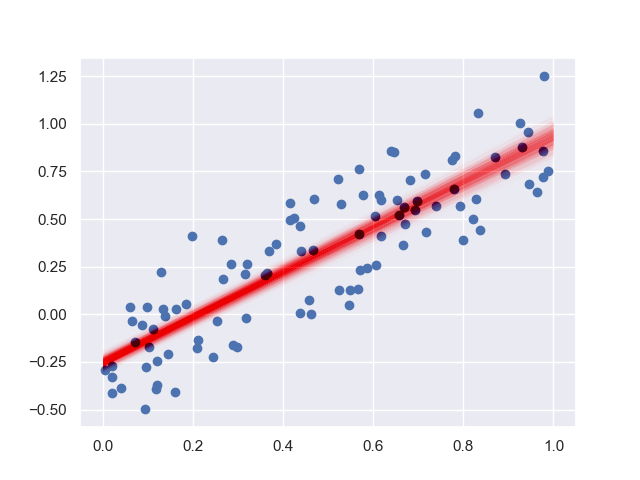

In [73]:
%matplotlib notebook
plt.scatter(X,y)
for w in lst_w:
    y_test = w.data[0].numpy()*X_test + w.data[1].numpy()
    plt.plot(X_test, y_test, alpha=0.005, linewidth=1, color='red')

<IPython.core.display.Javascript object>


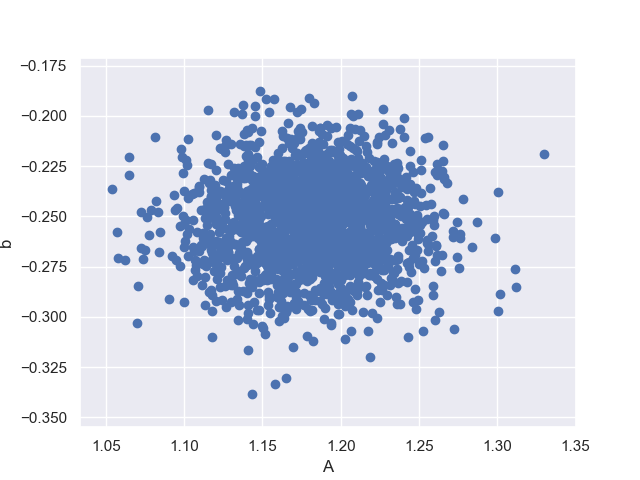

Text(0.5, 0, 'A')

In [76]:
%matplotlib notebook
W = torch.stack(lst_w)
plt.scatter(W[:,0].data, W[:,1].data)
plt.ylabel('b')
plt.xlabel('A')